# IXS/ETH Execution Quality: V2 vs Arrakis-Managed V4

Compare the IXS/ETH UniV2 pool (pre-migration) with the Arrakis-managed UniV4 pool (post-migration).

### Questions

1. What is the historical slippage for \$1K, \$5K, \$10K, and \$50K trades in both directions (IXS→ETH and ETH→IXS) on UniV2 before the migration?
2. What is the historical slippage for the same trade sizes and directions on UniV4 from migration to present?
3. How does execution quality compare over time across the migration boundary?
4. What does the current liquidity distribution of the UniV4 pool look like across tick ranges?
5. How does it compare to a theoretical full-range distribution, and how does concentration affect execution quality?

**Slippage (excluding fees)** = |spot price − avg execution price| / spot price × 100 − fee × 100

**Key Contracts:**
- UniV2 Pair: `0xC09bf2B1Bc8725903C509e8CAeef9190857215A8` (IXS=token0, WETH=token1)
- UniV4 Pool ID: `0xd54a5e98dc...` (ETH=currency0, IXS=currency1, fee=7000, tickSpacing=50)
- Arrakis Vault: `0x90bde935ce7feb6636afd5a1a0340af45eeae600`

In [1]:
import os
import sys
from datetime import datetime, UTC
from web3 import Web3
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append("..")

from src.config import (
    STATE_VIEW, QUOTER, IXS, ETH,
    UNIV2_PAIR, IXS_POOL_ID_BYTES,
    IXS_FEE, IXS_TICK_SPACING, IXS_HOOKS,
    ARRAKIS_VAULT, CHAINLINK_ETH_USD,
)
from src.abis import (
    STATEVIEW_ABI_EXTENDED, QUOTER_ABI,
    UNIV2_PAIR_ABI, ARRAKIS_VAULT_ABI, CHAINLINK_ABI,
)
from src.block_utils import (
    generate_daily_block_samples, blocks_to_timestamps,
    timestamps_to_dates, get_latest_block,
)
from src.price_feeds import get_eth_usd_at_block
from src.migration_detection import (
    find_v4_pool_creation_block, find_vault_first_deposit_block,
)
from src.v2_slippage import batch_v2_slippage_at_blocks
from src.v4_historical_slippage import batch_v4_slippage_at_blocks
from src.amm_math import sqrt_price_x96_to_price, theoretical_v4_slippage
from src.capital_efficiency import (
    compute_net_slippage_summary,
    find_breakeven_trade_size,
    compute_capital_efficiency_ratio,
)
from src.liquidity_distribution import fetch_liquidity_distribution
from src.cache import load_cache, save_cache

load_dotenv()
os.makedirs('plots', exist_ok=True)
os.makedirs('data', exist_ok=True)
w3 = Web3(Web3.HTTPProvider(os.getenv('rpc_url_mainnet')))
print(f'Connected: {w3.is_connected()}')
print(f'Latest block: {w3.eth.block_number}')

Connected: True
Latest block: 24506094


In [2]:
# Contract instances
stateview = w3.eth.contract(address=Web3.to_checksum_address(STATE_VIEW), abi=STATEVIEW_ABI_EXTENDED)  # V4 pool state: slot0, liquidity, ticks
quoter = w3.eth.contract(address=Web3.to_checksum_address(QUOTER), abi=QUOTER_ABI)  # V4 swap simulation: expected output for given input
pair = w3.eth.contract(address=Web3.to_checksum_address(UNIV2_PAIR), abi=UNIV2_PAIR_ABI)  # V2 pair: reserves, token ordering
vault = w3.eth.contract(address=Web3.to_checksum_address(ARRAKIS_VAULT), abi=ARRAKIS_VAULT_ABI)  # Arrakis vault: token balances, total supply
chainlink = w3.eth.contract(address=Web3.to_checksum_address(CHAINLINK_ETH_USD), abi=CHAINLINK_ABI)  # Chainlink oracle: on-chain ETH/USD price feed

# V2 token ordering: IXS=token0, WETH=token1
v2_token0 = pair.functions.token0().call()
ixs_is_token0_v2 = v2_token0.lower() == IXS.lower()
print(f"V2: IXS is token0 = {ixs_is_token0_v2}")

# V4 pool state via getSlot0: returns (sqrtPriceX96, tick, protocolFee, lpFee)
sp, tick, pf, lf = stateview.functions.getSlot0(IXS_POOL_ID_BYTES).call()
v4_price = float(sqrt_price_x96_to_price(sp))  # IXS per ETH
print("V4 slot0:")
print(f"  sqrtPriceX96 = {sp} → {v4_price:.2f} IXS/ETH")
print(f"  tick         = {tick}")
print(f"  protocolFee  = {pf}")
print(f"  lpFee        = {lf} ({lf/10000:.2f}%)")
print(f"  tickSpacing  = {IXS_TICK_SPACING}")

# V4 addresses for Quoter
currency0 = Web3.to_checksum_address(ETH)
currency1 = Web3.to_checksum_address(IXS)

V2: IXS is token0 = True
V4 slot0:
  sqrtPriceX96 = 14631488094488058986516320996287 → 34104.98 IXS/ETH
  tick         = 104377
  protocolFee  = 0
  lpFee        = 7000 (0.70%)
  tickSpacing  = 50


---

## Setup: Migration Detection

Binary search to find when the V4 pool was created and the Arrakis vault received its first deposit.

In [3]:
latest_block = get_latest_block(w3)
search_start = latest_block - 7200 * 365

print("Binary search for V4 pool creation...")
v4_creation_block = find_v4_pool_creation_block(
    stateview, IXS_POOL_ID_BYTES, search_start, latest_block
)

print("Binary search for vault first deposit...")
vault_deposit_block = find_vault_first_deposit_block(
    vault, search_start, latest_block
)

# Timestamps
event_ts = blocks_to_timestamps(w3, [v4_creation_block, vault_deposit_block])
event_dates = timestamps_to_dates(event_ts)
print(f"\nV4 pool creation:     block {v4_creation_block:,} → {event_dates[0]}")
print(f"Vault first deposit:  block {vault_deposit_block:,} → {event_dates[1]}")

# Use V4 creation as migration point (pool needs to exist for quotes)
MIGRATION_BLOCK = v4_creation_block
print(f"\n→ Migration block: {MIGRATION_BLOCK:,}")

Binary search for V4 pool creation...
Binary search for vault first deposit...

V4 pool creation:     block 23,982,496 → 2025-12-10
Vault first deposit:  block 23,982,428 → 2025-12-10

→ Migration block: 23,982,496


### Liquidity Landscape Around Migration

Three views of where liquidity sat before and after the migration:
1. **Arrakis Vault** — total assets under management (IXS + ETH, shown as TVL in ETH)
2. **V4 Pool** — active liquidity $L$ at the current tick (the swap engine)
3. **V2 Constant Product** $k = x \cdot y$ — the single number that captures V2 pool depth

The migration was not atomic

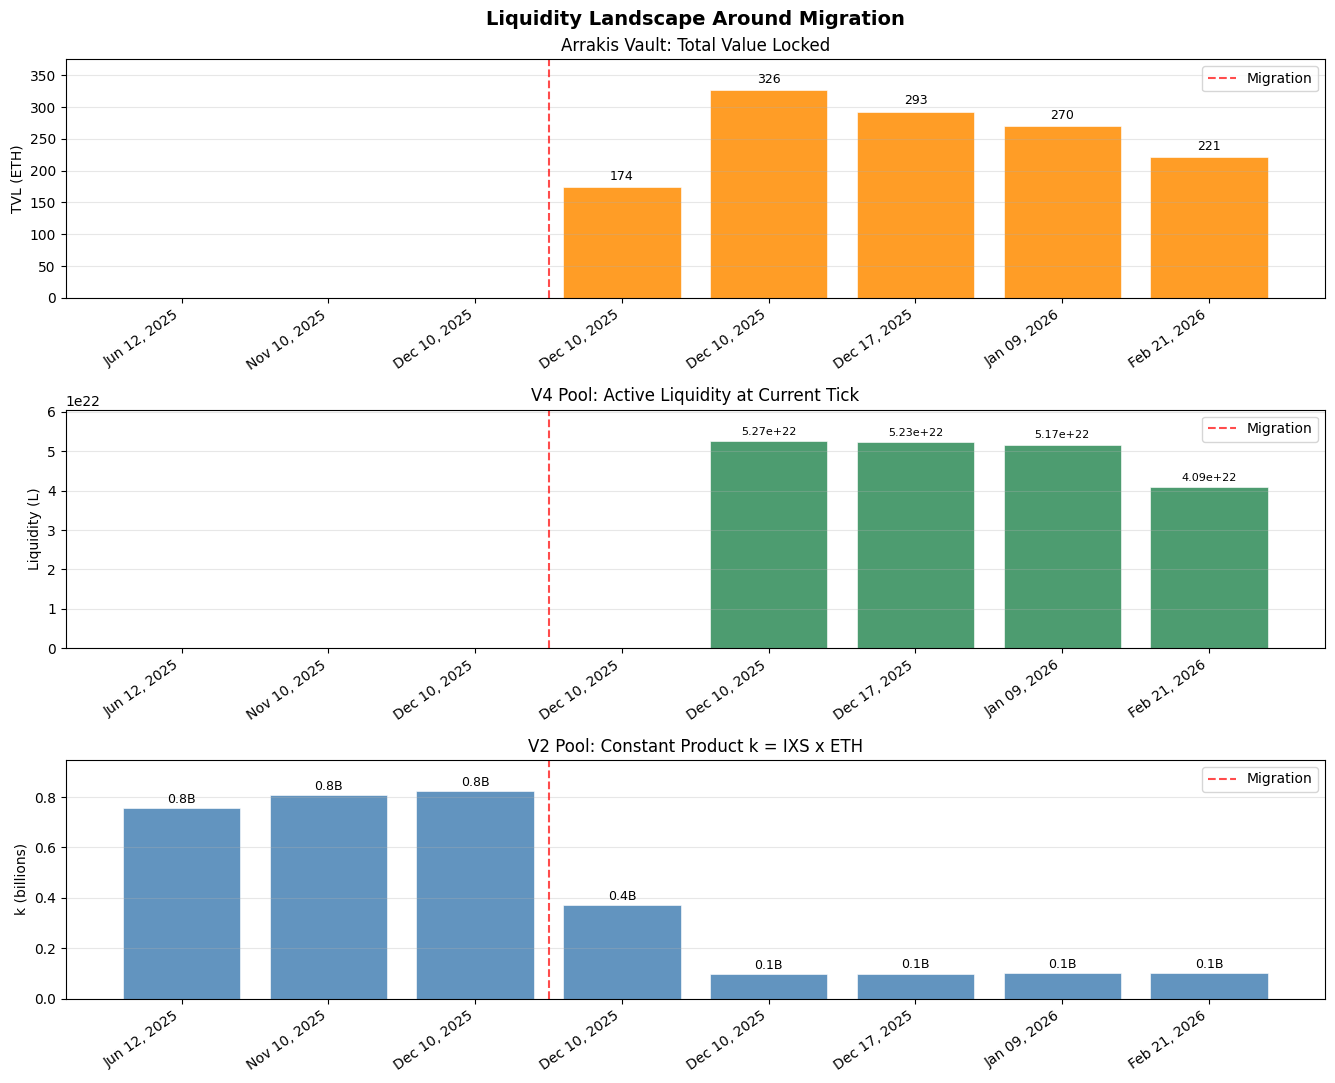

In [4]:
# Checkpoints around migration
check_points = {
    "6mo before": MIGRATION_BLOCK - 7200 * 180,
    "1mo before": MIGRATION_BLOCK - 7200 * 30,
    "6h before":  MIGRATION_BLOCK - 900,
    "Migration":  MIGRATION_BLOCK,
    "6h after":   MIGRATION_BLOCK + 900,
    "1wk after":  MIGRATION_BLOCK + 7200 * 7,
    "1mo after":  MIGRATION_BLOCK + 7200 * 30,
    "Now":        w3.eth.block_number,
}

# Fetch data at each checkpoint
labels = list(check_points.keys())
cp_blocks = list(check_points.values())

# Date labels
cp_ts = blocks_to_timestamps(w3, cp_blocks)
cp_dates = [datetime.fromtimestamp(ts, UTC).strftime("%b %d, %Y") for ts in cp_ts]

# V2: reserves → k
v2_k_vals = []
for block in cp_blocks:
    r0, r1, _ = pair.functions.getReserves().call(block_identifier=block)
    v2_k_vals.append((r0 / 1e18) * (r1 / 1e18) / 1e9)  # billions

# Vault: totalUnderlying → TVL in ETH (IXS converted via V2 spot price)
vault_tvl_eth = []
for block in cp_blocks:
    try:
        amt0, amt1 = vault.functions.totalUnderlying().call(block_identifier=block)
        # amt0 = IXS, amt1 = ETH (native)
        # Convert IXS to ETH using V2 reserves as price reference
        r0, r1, _ = pair.functions.getReserves().call(block_identifier=block)
        ixs_per_eth = r0 / r1 if r1 > 0 else 0
        ixs_in_eth = (amt0 / 1e18) / ixs_per_eth if ixs_per_eth > 0 else 0
        eth_val = amt1 / 1e18
        vault_tvl_eth.append(ixs_in_eth + eth_val)
    except Exception:
        vault_tvl_eth.append(0)

# V4: active liquidity L at current tick
v4_liq = []
for block in cp_blocks:
    try:
        L = stateview.functions.getLiquidity(IXS_POOL_ID_BYTES).call(block_identifier=block)
        v4_liq.append(float(L))
    except Exception:
        v4_liq.append(0)

# Bar plot: 3 panels
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 11))
fig.suptitle("Liquidity Landscape Around Migration", fontsize=14, fontweight="bold")

x = np.arange(len(labels))
migration_idx = labels.index("Migration")

# Panel 1: Arrakis Vault TVL (ETH) — darkorange (vault-specific, distinct from V2/V4)
ax1.bar(x, vault_tvl_eth, color="darkorange", alpha=0.85, edgecolor="white", linewidth=0.5)
ax1.axvline(migration_idx - 0.5, color="red", linestyle="--", alpha=0.7, label="Migration")
ax1.set_ylabel("TVL (ETH)")
ax1.set_title("Arrakis Vault: Total Value Locked")
ax1.set_xticks(x)
ax1.set_xticklabels(cp_dates, rotation=35, ha="right")
ax1.set_ylim(0, max(vault_tvl_eth) * 1.15)
ax1.legend()
ax1.grid(True, alpha=0.3, axis="y")
for i, v in enumerate(vault_tvl_eth):
    if v > 0:
        ax1.text(i, v + max(vault_tvl_eth) * 0.02, f"{v:.0f}", ha="center", va="bottom", fontsize=9)

# Panel 2: V4 Active Liquidity — seagreen (consistent with V4 throughout notebook)
ax2.bar(x, v4_liq, color="seagreen", alpha=0.85, edgecolor="white", linewidth=0.5)
ax2.axvline(migration_idx - 0.5, color="red", linestyle="--", alpha=0.7, label="Migration")
ax2.set_ylabel("Liquidity (L)")
ax2.set_title("V4 Pool: Active Liquidity at Current Tick")
ax2.set_xticks(x)
ax2.set_xticklabels(cp_dates, rotation=35, ha="right")
ax2.legend()
ax2.set_ylim(0, max(v4_liq) * 1.15)
ax2.grid(True, alpha=0.3, axis="y")
ax2.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
for i, v in enumerate(v4_liq):
    if v > 0:
        ax2.text(i, v + max(v4_liq) * 0.02, f"{v:.2e}", ha="center", va="bottom", fontsize=8)

# Panel 3: V2 Constant Product k — steelblue (consistent with V2 throughout notebook)
ax3.bar(x, v2_k_vals, color="steelblue", alpha=0.85, edgecolor="white", linewidth=0.5)
ax3.axvline(migration_idx - 0.5, color="red", linestyle="--", alpha=0.7, label="Migration")
ax3.set_ylabel("k (billions)")
ax3.set_title("V2 Pool: Constant Product k = IXS x ETH")
ax3.set_xticks(x)
ax3.set_xticklabels(cp_dates, rotation=35, ha="right")
ax3.legend()
ax3.set_ylim(0, max(v2_k_vals) * 1.15)
ax3.grid(True, alpha=0.3, axis="y")
for i, v in enumerate(v2_k_vals):
    ax3.text(i, v + max(v2_k_vals) * 0.01, f"{v:,.1f}B", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
fig.subplots_adjust(right=0.95)
plt.savefig("plots/ixs_v2_reserves_migration.png", dpi=150, bbox_inches="tight")
plt.show()

## Theory: Slippage Derivation

### V2: Constant-Product Slippage

Starting from the invariant $x \cdot y = k$, a swap of $\Delta x$ into the pool gives:

$$(x + \Delta x)(y - \Delta y) = k = x \cdot y$$

Solving for $\Delta y$:

$$\Delta y = \frac{y \cdot \Delta x}{x + \Delta x}$$

The spot price is $P = y/x$, and the execution price is $P_{\text{exec}} = \Delta y / \Delta x$. Slippage is:

$$S_{\text{V2}} = 1 - \frac{P_{\text{exec}}}{P} = 1 - \frac{x}{x + \Delta x} = \frac{\Delta x}{x + \Delta x}$$

This is hyperbolic in $\Delta x$ — slippage grows sub-linearly and depends on the **total reserve** $x$.

### V4: Concentrated Liquidity Slippage

In V4, liquidity $L$ is concentrated in a range $[p_a, p_b]$. Within that range, the invariant is:

$$X_v \cdot Y_v = L^2$$

where $X_v, Y_v$ are **virtual reserves** — the reserves that would exist if the position covered the full range. The real reserves within range are:

$$x_{\text{real}} = L\left(\frac{1}{\sqrt{p}} - \frac{1}{\sqrt{p_b}}\right), \quad y_{\text{real}} = L\left(\sqrt{p} - \sqrt{p_a}\right)$$

A swap of $\Delta x$ changes the price from $p$ to $p'$:

$$p' = \frac{p}{\left(1 + \frac{\Delta x \sqrt{p}}{L}\right)^2}$$

The key insight: if $L$ is large relative to $\Delta x \sqrt{p}$, the price barely moves. Concentrated liquidity achieves a large $L$ by deploying capital in a narrow range rather than spreading it across all prices.

Slippage becomes:

$$S_{\text{V4}} = 1 - \frac{1}{\left(1 + \frac{\Delta x \sqrt{p}}{L}\right)^2}$$

**V2 vs V4:** V2 slippage depends on total reserve $x$. V4 slippage depends on **local liquidity** $L$ at the current tick. Same TVL, but concentrated into a narrower range, produces a much larger $L$ and therefore lower slippage.

### Net Cost

Total cost to the trader = price impact + LP fee:

$$C_{\text{net}} = S_{\text{gross}} + f$$

V2 fee $f = 0.30\%$, V4 fee $f = 0.70\%$. The 0.40pp fee premium means V4 must save at least 0.40pp in price impact to break even on net cost.

---

## Q1. Historical Slippage on UniV2 (Pre-Migration)

Slippage for \$1K, \$5K, \$10K, \$50K in both directions using the constant-product formula: $S = \frac{\Delta x}{x + \Delta x}$

**Period:** ~6 months to 1 week before migration (~Jun 14 – Dec 3, 2025). The last week is excluded to avoid migration-related liquidity drainage distorting V2 slippage.

1 `getReserves()` RPC call per block — all trade sizes computed locally. **V2 fee: 0.30%**

In [9]:
# Pre-migration: ~6 months before migration, stopping 1 week before to avoid migration noise
PRE_START = MIGRATION_BLOCK - 7200 * 180
PRE_END = MIGRATION_BLOCK - 7200 * 7  # 1 week before migration
pre_blocks = generate_daily_block_samples(PRE_START, PRE_END)
print(f"V2 sample blocks: {len(pre_blocks)} (6mo to 1wk before migration)")

# Trade sizes: USD → ETH wei (using mid-period ETH/USD)
TRADE_SIZES_USD = [1_000, 5_000, 10_000, 50_000]
mid_block = (PRE_START + PRE_END) // 2
eth_usd_ref = get_eth_usd_at_block(chainlink, mid_block)
print(f"Reference ETH/USD: ${eth_usd_ref:,.2f}")

trade_eth_wei = [int((usd / eth_usd_ref) * 1e18) for usd in TRADE_SIZES_USD]

# IXS trade amounts (for sell direction): use V2 price at mid-point
r0, r1, _ = pair.functions.getReserves().call(block_identifier=mid_block)
ixs_eth_mid = r1 / r0  # ETH per IXS (IXS is token0)
trade_ixs_wei = [int((usd / eth_usd_ref / ixs_eth_mid) * 1e18) for usd in TRADE_SIZES_USD]

print(f"IXS/ETH at midpoint: {ixs_eth_mid:.10f}")
for usd, eth_w, ixs_w in zip(TRADE_SIZES_USD, trade_eth_wei, trade_ixs_wei):
    print(f"  ${usd:>6,} → {eth_w/1e18:.4f} ETH, {ixs_w/1e18:,.0f} IXS")

V2 sample blocks: 174 (6mo to 1wk before migration)
Reference ETH/USD: $4,303.60
IXS/ETH at midpoint: 0.0000234712
  $ 1,000 → 0.2324 ETH, 9,900 IXS
  $ 5,000 → 1.1618 ETH, 49,500 IXS
  $10,000 → 2.3236 ETH, 99,000 IXS
  $50,000 → 11.6182 ETH, 494,999 IXS


In [10]:
# Direction 1: ETH → IXS (buying IXS)
_params = {"blocks": pre_blocks, "amounts": trade_eth_wei, "direction": "buy"}
v2_buy_results = load_cache("v2_buy_slippage", _params)
if v2_buy_results is None:
    print(f"Fetching V2 buy-IXS slippage at {len(pre_blocks)} blocks...")
    v2_buy_results = batch_v2_slippage_at_blocks(
        pair, pre_blocks, trade_eth_wei, ixs_is_token0_v2, buy_ixs=True
    )
    save_cache("v2_buy_slippage", v2_buy_results, _params)
v2_buy_ok = [r for r in v2_buy_results if "error" not in r]
print(f"V2 buy: {len(v2_buy_ok)}/{len(v2_buy_results)} blocks OK")

  Cache hit: v2_buy_slippage_19e578ed.json
V2 buy: 174/174 blocks OK


In [11]:
# Direction 2: IXS → ETH (selling IXS)
_params = {"blocks": pre_blocks, "amounts": trade_ixs_wei, "direction": "sell"}
v2_sell_results = load_cache("v2_sell_slippage", _params)
if v2_sell_results is None:
    print(f"Fetching V2 sell-IXS slippage at {len(pre_blocks)} blocks...")
    v2_sell_results = batch_v2_slippage_at_blocks(
        pair, pre_blocks, trade_ixs_wei, ixs_is_token0_v2, buy_ixs=False
    )
    save_cache("v2_sell_slippage", v2_sell_results, _params)
v2_sell_ok = [r for r in v2_sell_results if "error" not in r]
print(f"V2 sell: {len(v2_sell_ok)}/{len(v2_sell_results)} blocks OK")

  Cache hit: v2_sell_slippage_1b7099fc.json
V2 sell: 174/174 blocks OK


### Slippage vs Trade Size (V2)

How does slippage scale with trade size? From the constant-product formula $S = \frac{\Delta x}{x + \Delta x}$, the relationship is hyperbolic — sub-linear growth. Each faint line is one sampled day; the bold line is the mean across the pre-migration period.

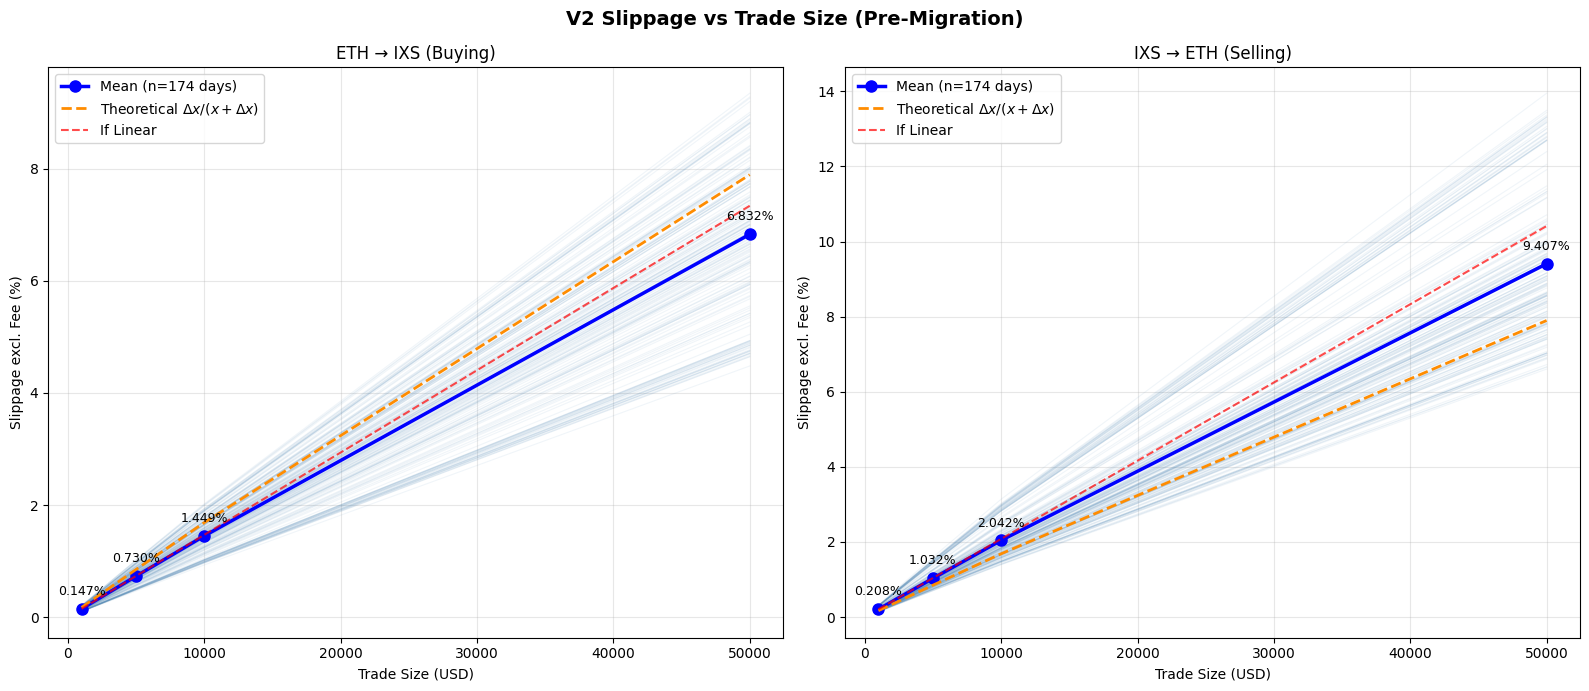


Trade Size   ETH→IXS Avg %    IXS→ETH Avg %   
--------------------------------------------
$ 1,000     0.1468           0.2082          
$ 5,000     0.7298           1.0321          
$10,000     1.4485           2.0421          
$50,000     6.8322           9.4070          


In [12]:
# Extract slippage vs trade size curves per sampled block

def get_trade(r, amt):
    """Get trade result, handling JSON string-key cache."""
    trades = r.get("trades", {})
    return trades.get(amt) or trades.get(str(amt)) or {}

def has_trade(r, amt):
    """Check if a valid trade exists for this amount."""
    t = get_trade(r, amt)
    return bool(t) and "error" not in t and "gross_slippage_pct" in t

def extract_slippage_curves(results, trade_amounts):
    """Extract per-block slippage curves: list of [slippage_per_size] arrays."""
    curves = []
    for r in results:
        if "error" in r:
            continue
        row = []
        valid = True
        for amt in trade_amounts:
            t = get_trade(r, amt)
            if "error" in t or "gross_slippage_pct" not in t:
                valid = False
                break
            row.append(t["gross_slippage_pct"])
        if valid:
            curves.append(row)
    return np.array(curves) if curves else np.array([])

# Get mean V2 reserves for theoretical curve
r0_mid, r1_mid, _ = pair.functions.getReserves().call(block_identifier=mid_block)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle("V2 Slippage vs Trade Size (Pre-Migration)", fontsize=14, fontweight="bold")

for ax, label, v2_results, amounts, reserve_in in [
    (ax1, "ETH → IXS (Buying)", v2_buy_results, trade_eth_wei, r1_mid),
    (ax2, "IXS → ETH (Selling)", v2_sell_results, trade_ixs_wei, r0_mid),
]:
    curves = extract_slippage_curves(v2_results, amounts)
    if len(curves) == 0:
        ax.text(0.5, 0.5, "No data", transform=ax.transAxes, ha="center")
        continue

    # Individual sample days (faint)
    for curve in curves:
        ax.plot(TRADE_SIZES_USD, curve, color="steelblue", alpha=0.08, linewidth=0.8)

    # Mean curve (bold)
    mean_curve = curves.mean(axis=0)
    ax.plot(TRADE_SIZES_USD, mean_curve, "b-o", linewidth=2.5, markersize=8,
            label=f"Mean (n={len(curves)} days)")

    # Theoretical V2: S = Δx / (x + Δx) using mid-period reserves
    theoretical_v2 = [(amt / (reserve_in + amt)) * 100 for amt in amounts]
    ax.plot(TRADE_SIZES_USD, theoretical_v2, color="darkorange", linestyle="--", linewidth=2,
            label=r"Theoretical $\Delta x/(x+\Delta x)$")

    # Linear reference from smallest trade
    if mean_curve[0] > 0:
        linear = [mean_curve[0] * (usd / TRADE_SIZES_USD[0]) for usd in TRADE_SIZES_USD]
        ax.plot(TRADE_SIZES_USD, linear, "r--", linewidth=1.5, alpha=0.7, label="If Linear")

    ax.set_xlabel("Trade Size (USD)")
    ax.set_ylabel("Slippage excl. Fee (%)")
    ax.set_title(label)
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Annotate mean values
    for i, (usd, s) in enumerate(zip(TRADE_SIZES_USD, mean_curve)):
        ax.annotate(f"{s:.3f}%", (usd, s), textcoords="offset points",
                    xytext=(0, 10), ha="center", fontsize=9)

plt.tight_layout()
plt.savefig("plots/ixs_v2_slippage_vs_size.png", dpi=150, bbox_inches="tight")
plt.show()

# Print summary table
print(f"\n{'Trade Size':<12} {'ETH→IXS Avg %':<16} {'IXS→ETH Avg %':<16}")
print("-" * 44)
buy_curves = extract_slippage_curves(v2_buy_results, trade_eth_wei)
sell_curves = extract_slippage_curves(v2_sell_results, trade_ixs_wei)
for i, usd in enumerate(TRADE_SIZES_USD):
    buy_avg = buy_curves[:, i].mean() if len(buy_curves) > 0 else 0
    sell_avg = sell_curves[:, i].mean() if len(sell_curves) > 0 else 0
    print(f"${usd:>6,}     {buy_avg:<16.4f} {sell_avg:<16.4f}")

---

## Q2. Historical Slippage on UniV4 (Post-Migration)

Same trade sizes and directions on V4 from migration to present. Uses `StateView.getSlot0()` for spot price and `Quoter.quoteExactInputSingle()` for execution price at each historical block.

**Period:** 1 week after migration to present (~Dec 17, 2025 – Feb 21, 2026). The first week is excluded to avoid early liquidity settling distorting V4 slippage. **V4 fee: 0.70%**

In [13]:
# Post-migration: start 1 week after migration to avoid early liquidity settling noise
POST_START = MIGRATION_BLOCK + 7200 * 7  # 1 week after migration
POST_END = (latest_block // 7200) * 7200  # pin to day boundary for stable cache keys
post_blocks = generate_daily_block_samples(POST_START, POST_END)
print(f"V4 sample blocks: {len(post_blocks)} (1wk after migration to now)")

# V4 trade amounts: same USD values, converted to ETH wei
# For IXS→ETH direction, convert USD to IXS using V4 spot price
eth_usd_post_ref = get_eth_usd_at_block(chainlink, (POST_START + POST_END) // 2)
sp_mid, _, _, _ = stateview.functions.getSlot0(IXS_POOL_ID_BYTES).call(
    block_identifier=(POST_START + POST_END) // 2
)
v4_price_mid = float(sqrt_price_x96_to_price(sp_mid))  # IXS per ETH
ixs_eth_mid_v4 = 1.0 / v4_price_mid  # ETH per IXS

trade_eth_wei_v4 = [int((usd / eth_usd_post_ref) * 1e18) for usd in TRADE_SIZES_USD]
trade_ixs_wei_v4 = [int((usd / eth_usd_post_ref / ixs_eth_mid_v4) * 1e18) for usd in TRADE_SIZES_USD]

print(f"V4 reference prices: ETH=${eth_usd_post_ref:.2f}, {v4_price_mid:.2f} IXS/ETH")

V4 sample blocks: 67 (1wk after migration to now)
V4 reference prices: ETH=$3195.99, 32417.97 IXS/ETH


In [14]:
# Direction 1: ETH → IXS (zero_for_one=True, swapping currency0 for currency1)
_params = {"blocks": post_blocks, "amounts": trade_eth_wei_v4, "direction": "buy"}
v4_buy_results = load_cache("v4_buy_slippage", _params)
if v4_buy_results is None:
    print(f"Fetching V4 buy-IXS slippage at {len(post_blocks)} blocks × {len(trade_eth_wei_v4)} sizes...")
    v4_buy_results = batch_v4_slippage_at_blocks(
        stateview, quoter, IXS_POOL_ID_BYTES,
        post_blocks, trade_eth_wei_v4,
        currency0, currency1,
        IXS_FEE, IXS_TICK_SPACING, IXS_HOOKS,
        zero_for_one=True,
    )
    save_cache("v4_buy_slippage", v4_buy_results, _params)
v4_buy_ok = [r for r in v4_buy_results if "error" not in r]
print(f"V4 buy: {len(v4_buy_ok)}/{len(v4_buy_results)} blocks OK")

  Cache hit: v4_buy_slippage_00d5f6cb.json
V4 buy: 67/67 blocks OK


In [15]:
# Direction 2: IXS → ETH (zero_for_one=False, swapping currency1 for currency0)
_params = {"blocks": post_blocks, "amounts": trade_ixs_wei_v4, "direction": "sell"}
v4_sell_results = load_cache("v4_sell_slippage", _params)
if v4_sell_results is None:
    print(f"Fetching V4 sell-IXS slippage at {len(post_blocks)} blocks × {len(trade_ixs_wei_v4)} sizes...")
    v4_sell_results = batch_v4_slippage_at_blocks(
        stateview, quoter, IXS_POOL_ID_BYTES,
        post_blocks, trade_ixs_wei_v4,
        currency0, currency1,
        IXS_FEE, IXS_TICK_SPACING, IXS_HOOKS,
        zero_for_one=False,
    )
    save_cache("v4_sell_slippage", v4_sell_results, _params)
v4_sell_ok = [r for r in v4_sell_results if "error" not in r]
print(f"V4 sell: {len(v4_sell_ok)}/{len(v4_sell_results)} blocks OK")

  Cache hit: v4_sell_slippage_ca6b2cd9.json
V4 sell: 67/67 blocks OK


### Slippage vs Trade Size (V4 vs V2)

Same view as Q1 but now with V4 post-migration overlaid on V2 for direct comparison. V4 actual values come from the on-chain Quoter, which correctly simulates tick crossings for larger trades.

The theoretical line walks through the actual tick-band liquidity distribution: starting at the current tick's $L$, it steps into adjacent bands as the trade consumes available liquidity in each range. This captures the real cost of crossing into ranges with different (or zero) liquidity, unlike a constant-$L$ formula.

In [16]:
# Fetch V4 liquidity distribution (used for theoretical slippage and Q4 plots)
df_liq, slot_info = fetch_liquidity_distribution(
    stateview, IXS_POOL_ID_BYTES, IXS_TICK_SPACING, search_range=100
)
print(f"Initialized tick ranges: {len(df_liq)}")
print(f"Current tick: {slot_info['tick']}, current L: {slot_info['liquidity']:,}")
for _, row in df_liq.iterrows():
    active = " <- ACTIVE" if row['tick_lower'] <= slot_info['tick'] < row['tick_upper'] else ""
    print(f"  [{int(row['tick_lower']):>8} -> {int(row['tick_upper']):>8}]  L = {int(row['active_liquidity']):>25,}{active}")

Initialized tick ranges: 6
Current tick: 104377, current L: 40,944,451,797,831,193,660,012
  [   92100 ->    92150]  L =                         0
  [   92150 ->    92950]  L = 40,944,451,797,831,193,660,012
  [   92950 ->   103900]  L = 48,812,350,825,352,456,355,462
  [  103900 ->   104350]  L = 40,944,451,797,831,193,660,012
  [  104350 ->   115700]  L = 40,944,451,797,831,193,660,012 <- ACTIVE
  [  115700 ->   115750]  L =                         0


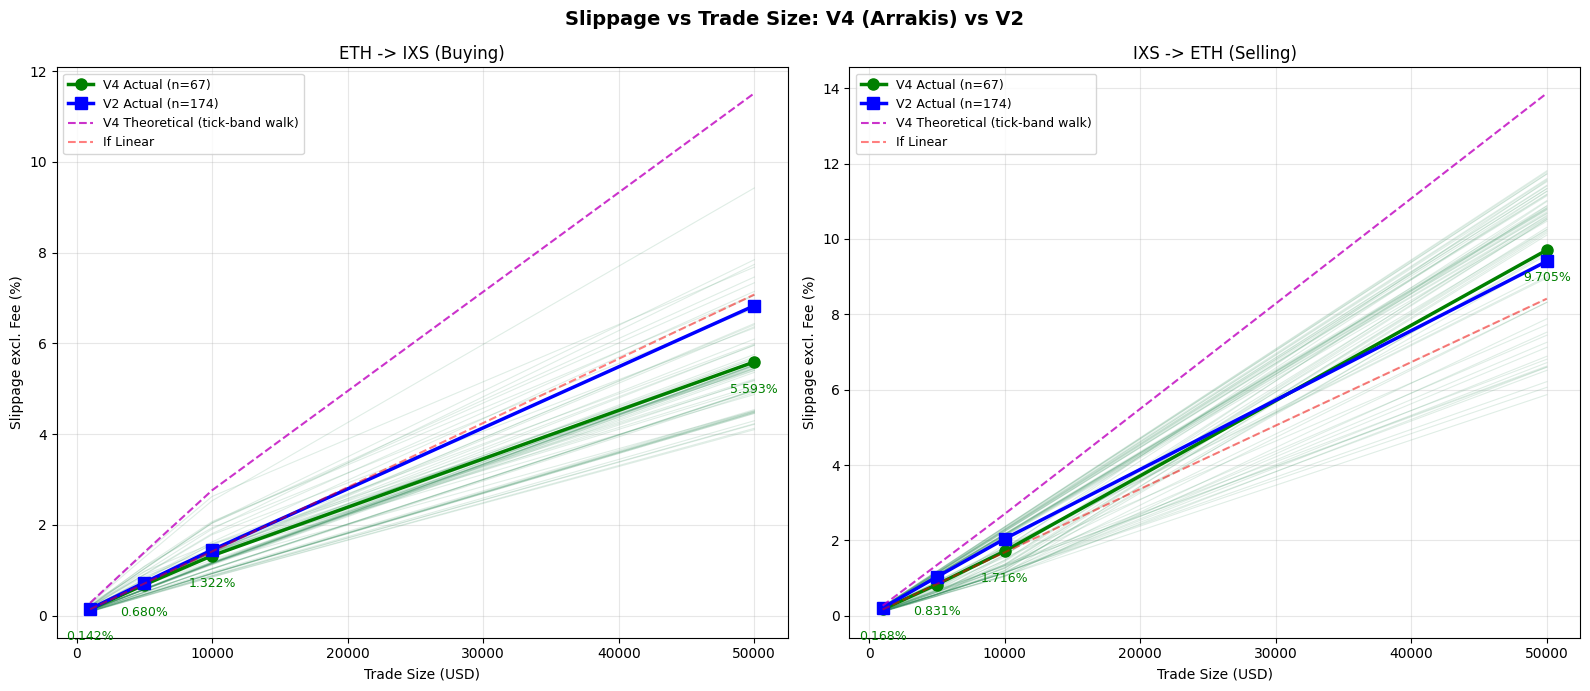


Trade Size   V2 Buy %     V4 Buy %     V2 Sell %    V4 Sell %   
------------------------------------------------------------
$ 1,000     0.1468       0.1416       0.2082       0.1683      
$ 5,000     0.7298       0.6804       1.0321       0.8309      
$10,000     1.4485       1.3224       2.0421       1.7159      
$50,000     6.8322       5.5926       9.4070       9.7051      


In [17]:
current_tick = slot_info["tick"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle("Slippage vs Trade Size: V4 (Arrakis) vs V2", fontsize=14, fontweight="bold")

for ax, label, v4_results, v4_amounts, v2_results, v2_amounts, input_amounts, is_buy in [
    (ax1, "ETH -> IXS (Buying)",
     v4_buy_results, trade_eth_wei_v4, v2_buy_results, trade_eth_wei, trade_eth_wei_v4, True),
    (ax2, "IXS -> ETH (Selling)",
     v4_sell_results, trade_ixs_wei_v4, v2_sell_results, trade_ixs_wei, trade_ixs_wei_v4, False),
]:
    v4_curves = extract_slippage_curves(v4_results, v4_amounts)
    v2_curves = extract_slippage_curves(v2_results, v2_amounts)

    if len(v4_curves) == 0:
        ax.text(0.5, 0.5, "No V4 data", transform=ax.transAxes, ha="center")
        continue

    # V4 individual days (faint green)
    for curve in v4_curves:
        ax.plot(TRADE_SIZES_USD, curve, color="seagreen", alpha=0.15, linewidth=0.8)

    # V4 mean (bold green)
    v4_mean = v4_curves.mean(axis=0)
    ax.plot(TRADE_SIZES_USD, v4_mean, "g-o", linewidth=2.5, markersize=8,
            label=f"V4 Actual (n={len(v4_curves)})")

    # V2 mean (bold blue)
    if len(v2_curves) > 0:
        v2_mean = v2_curves.mean(axis=0)
        ax.plot(TRADE_SIZES_USD, v2_mean, "b-s", linewidth=2.5, markersize=8,
                label=f"V2 Actual (n={len(v2_curves)})")

    # Theoretical V4: step through actual tick bands (not constant L)
    theoretical_v4 = [theoretical_v4_slippage(amt, is_buy, current_tick, df_liq)
                      for amt in input_amounts]
    ax.plot(TRADE_SIZES_USD, theoretical_v4, "m--", linewidth=1.5, alpha=0.8,
            label="V4 Theoretical (tick-band walk)")

    # Linear reference from V4
    if v4_mean[0] > 0:
        linear = [v4_mean[0] * (usd / TRADE_SIZES_USD[0]) for usd in TRADE_SIZES_USD]
        ax.plot(TRADE_SIZES_USD, linear, "r--", linewidth=1.5, alpha=0.5, label="If Linear")

    ax.set_xlabel("Trade Size (USD)")
    ax.set_ylabel("Slippage excl. Fee (%)")
    ax.set_title(label)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

    # Annotate V4 mean (below line so labels don't collide with lines above)
    for i, (usd, s) in enumerate(zip(TRADE_SIZES_USD, v4_mean)):
        ax.annotate(f"{s:.3f}%", (usd, s), textcoords="offset points",
                    xytext=(0, -15), ha="center", va="top", fontsize=9, color="green")

plt.tight_layout()
plt.savefig("plots/ixs_v4_slippage_vs_size.png", dpi=150, bbox_inches="tight")
plt.show()

# Print comparison table
print(f"\n{'Trade Size':<12} {'V2 Buy %':<12} {'V4 Buy %':<12} {'V2 Sell %':<12} {'V4 Sell %':<12}")
print("-" * 60)
v2_buy_c = extract_slippage_curves(v2_buy_results, trade_eth_wei)
v2_sell_c = extract_slippage_curves(v2_sell_results, trade_ixs_wei)
v4_buy_c = extract_slippage_curves(v4_buy_results, trade_eth_wei_v4)
v4_sell_c = extract_slippage_curves(v4_sell_results, trade_ixs_wei_v4)
for i, usd in enumerate(TRADE_SIZES_USD):
    v2b = v2_buy_c[:, i].mean() if len(v2_buy_c) > 0 else 0
    v4b = v4_buy_c[:, i].mean() if len(v4_buy_c) > 0 else 0
    v2s = v2_sell_c[:, i].mean() if len(v2_sell_c) > 0 else 0
    v4s = v4_sell_c[:, i].mean() if len(v4_sell_c) > 0 else 0
    print(f"${usd:>6,}     {v2b:<12.4f} {v4b:<12.4f} {v2s:<12.4f} {v4s:<12.4f}")

---

## Q3. Execution Quality Over Time

2×2 grid per direction: one panel per trade size, V2 (blue, pre-migration) and V4 (green, post-migration) on the same time axis.

In [18]:
# Fetch timestamps for date labels
_ts_params = {"pre_blocks": pre_blocks, "post_blocks": post_blocks, "migration": MIGRATION_BLOCK}
_cached_ts = load_cache("block_timestamps", _ts_params)
if _cached_ts is None:
    print("Fetching timestamps...")
    pre_ts = blocks_to_timestamps(w3, pre_blocks)
    post_ts = blocks_to_timestamps(w3, post_blocks)
    migration_ts = blocks_to_timestamps(w3, [MIGRATION_BLOCK])
    save_cache("block_timestamps", {"pre": pre_ts, "post": post_ts, "migration": migration_ts}, _ts_params)
else:
    pre_ts = _cached_ts["pre"]
    post_ts = _cached_ts["post"]
    migration_ts = _cached_ts["migration"]

pre_dates = timestamps_to_dates(pre_ts)
post_dates = timestamps_to_dates(post_ts)
migration_date = timestamps_to_dates(migration_ts)[0]
print(f"Migration date: {migration_date}")

  Cache hit: block_timestamps_8965f1f0.json
Migration date: 2025-12-10


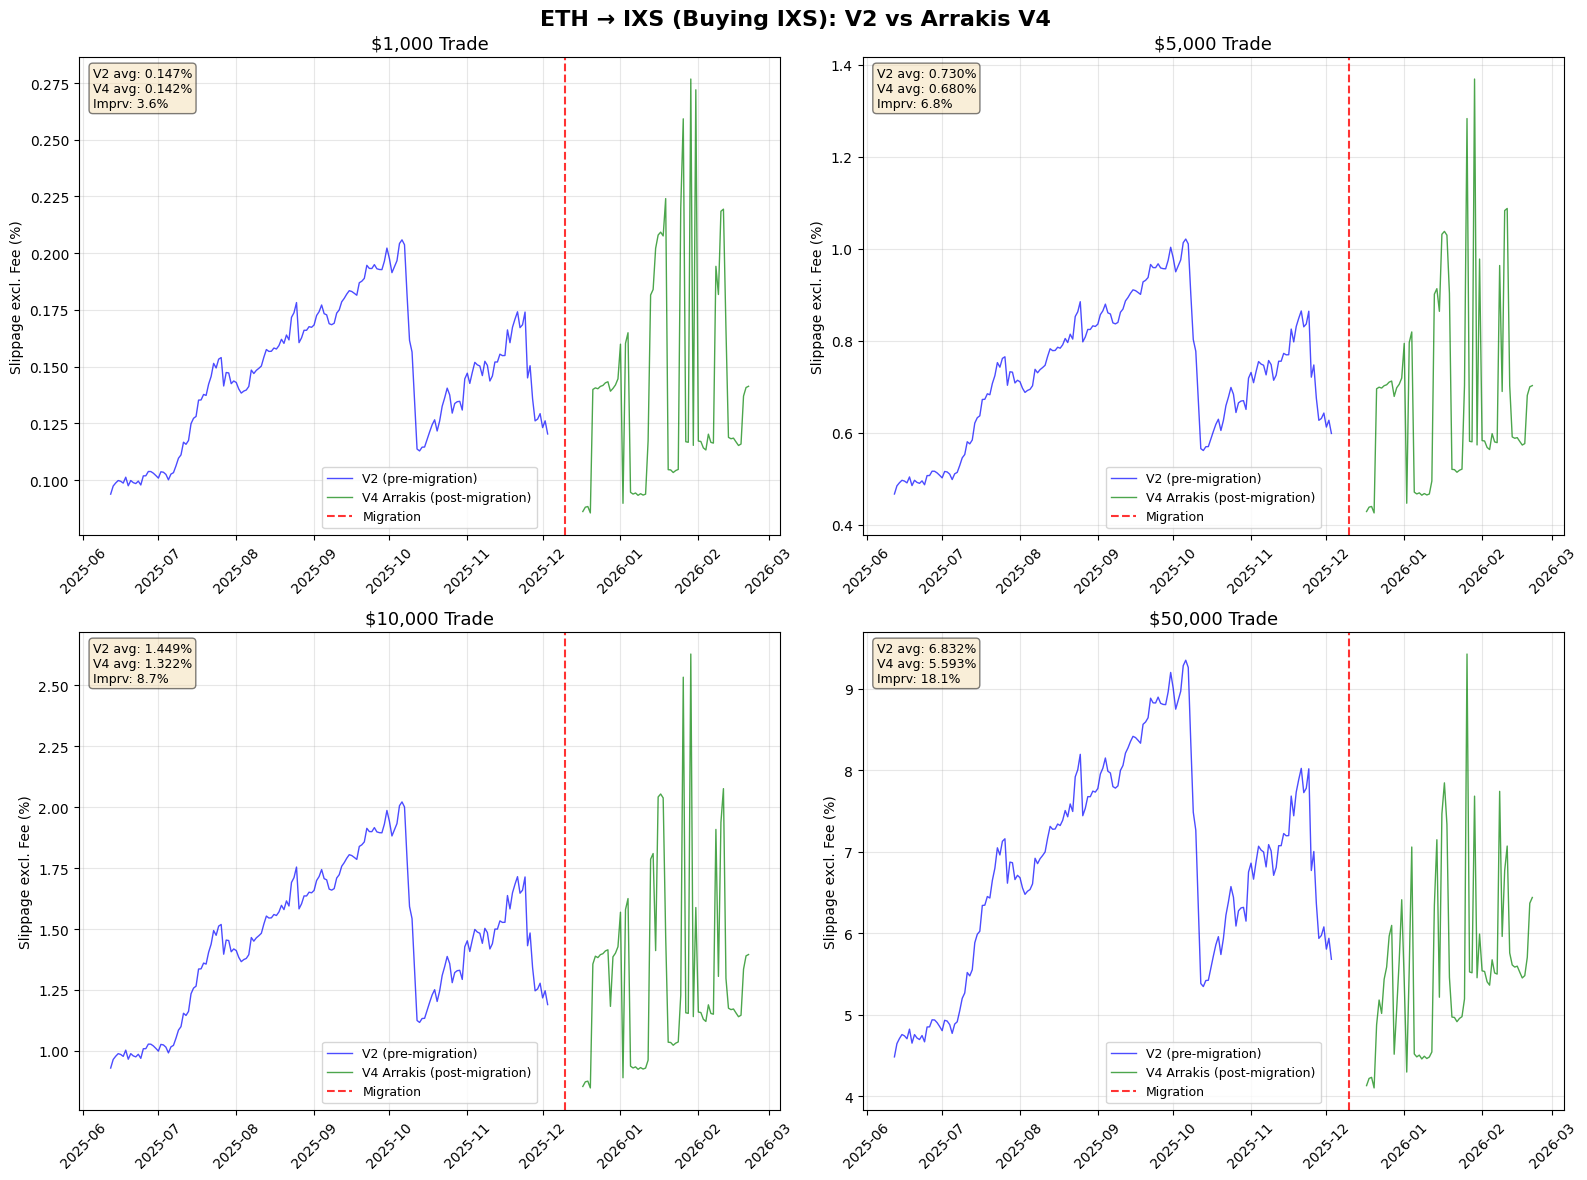

In [19]:
def plot_slippage_comparison(v2_results, v4_results, v2_amounts, v4_amounts,
                             pre_dates, post_dates, migration_date, title, sizes_usd):
    """Plot 2x2 grid comparing V2 vs V4 slippage."""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(title, fontsize=16, fontweight='bold')

    for idx, (usd, v2_amt, v4_amt) in enumerate(zip(sizes_usd, v2_amounts, v4_amounts)):
        ax = axes[idx // 2][idx % 2]

        # V2 data
        v2_x, v2_y = [], []
        for i, r in enumerate(v2_results):
            if "error" not in r and has_trade(r, v2_amt):
                v2_x.append(pd.to_datetime(pre_dates[i]))
                v2_y.append(get_trade(r, v2_amt)["gross_slippage_pct"])

        # V4 data
        v4_x, v4_y = [], []
        for i, r in enumerate(v4_results):
            if "error" not in r and has_trade(r, v4_amt):
                v4_x.append(pd.to_datetime(post_dates[i]))
                v4_y.append(get_trade(r, v4_amt)["gross_slippage_pct"])

        ax.plot(v2_x, v2_y, 'b-', alpha=0.7, linewidth=1, label='V2 (pre-migration)')
        ax.plot(v4_x, v4_y, 'g-', alpha=0.7, linewidth=1, label='V4 Arrakis (post-migration)')
        ax.axvline(pd.to_datetime(migration_date), color='red', linestyle='--', alpha=0.8, label='Migration')

        ax.set_title(f'${usd:,} Trade', fontsize=13)
        ax.set_ylabel('Slippage excl. Fee (%)')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)

        if v2_y and v4_y:
            v2_avg = np.mean(v2_y)
            v4_avg = np.mean(v4_y)
            imp = (v2_avg - v4_avg) / v2_avg * 100 if v2_avg > 0 else 0
            ax.text(0.02, 0.98, f'V2 avg: {v2_avg:.3f}%\nV4 avg: {v4_avg:.3f}%\nImprv: {imp:.1f}%',
                    transform=ax.transAxes, va='top', fontsize=9,
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    return fig

# Buy direction: ETH → IXS
fig = plot_slippage_comparison(
    v2_buy_results, v4_buy_results, trade_eth_wei, trade_eth_wei_v4,
    pre_dates, post_dates, migration_date,
    'ETH → IXS (Buying IXS): V2 vs Arrakis V4', TRADE_SIZES_USD
)
plt.savefig('plots/ixs_buy_execution_quality.png', dpi=150, bbox_inches='tight')
plt.show()

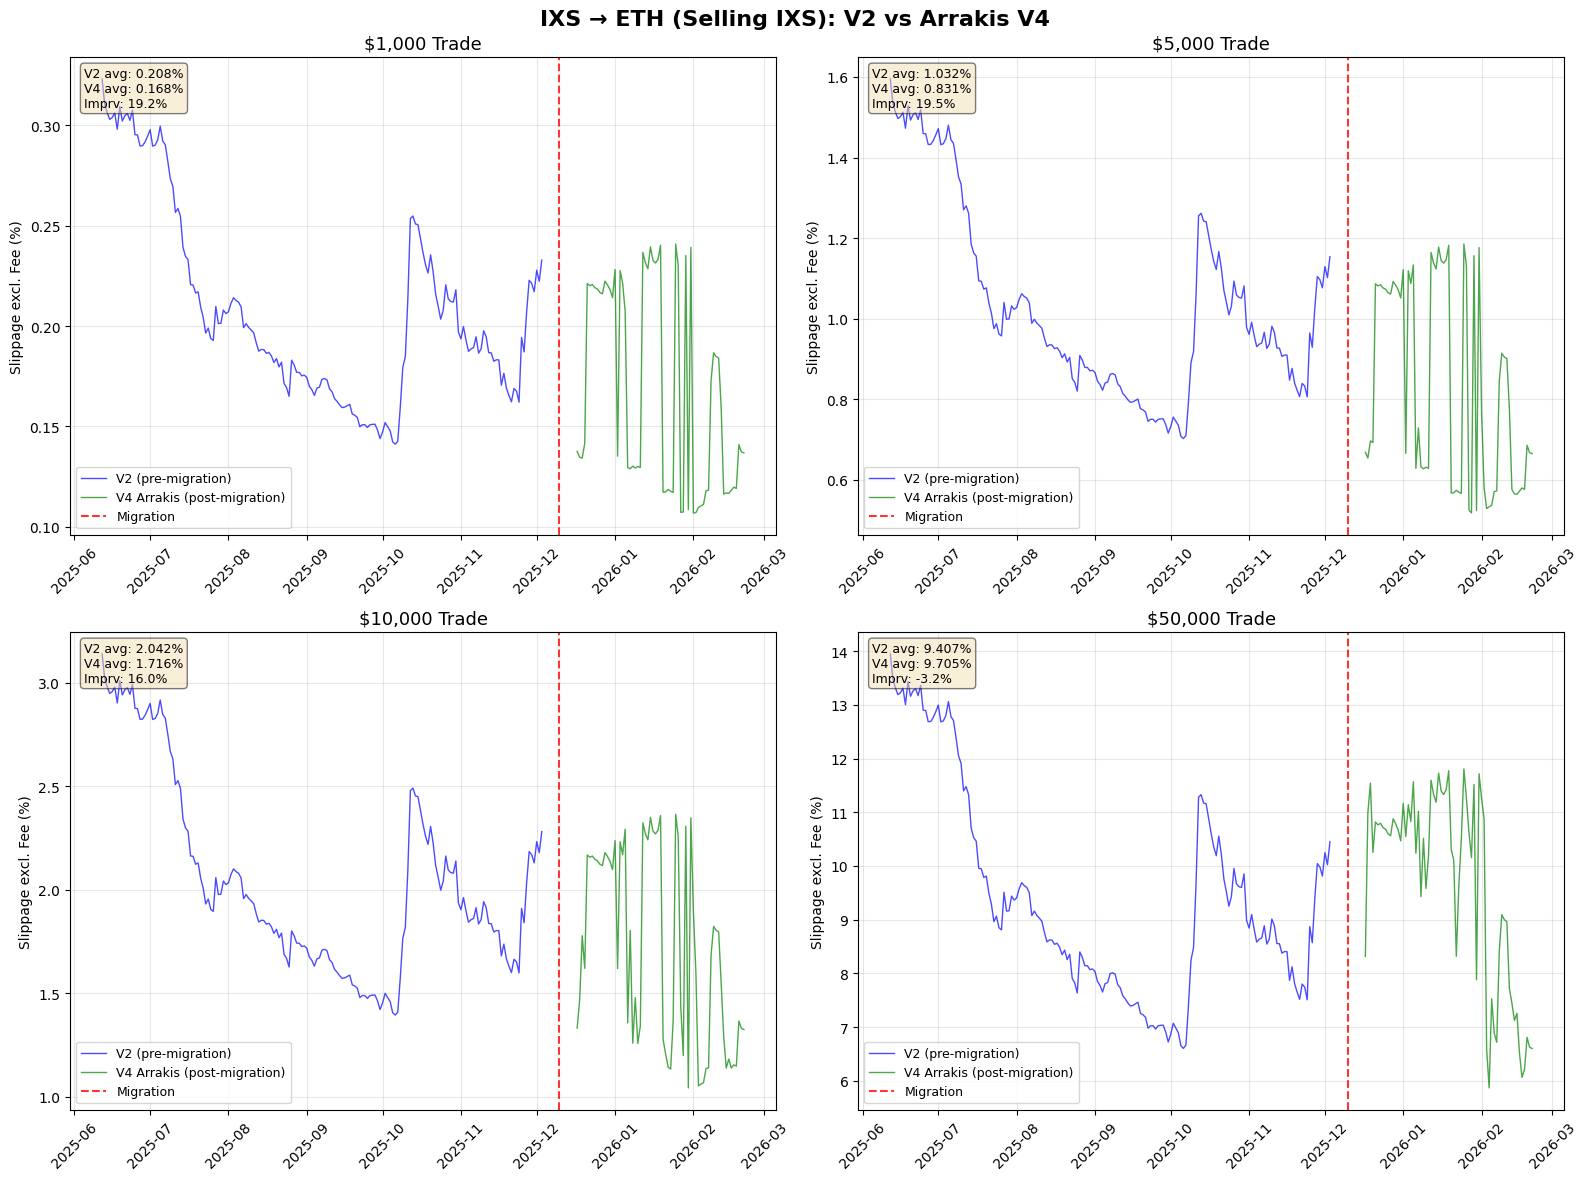

In [20]:
# Sell direction: IXS → ETH
fig = plot_slippage_comparison(
    v2_sell_results, v4_sell_results, trade_ixs_wei, trade_ixs_wei_v4,
    pre_dates, post_dates, migration_date,
    'IXS → ETH (Selling IXS): V2 vs Arrakis V4', TRADE_SIZES_USD
)
plt.savefig('plots/ixs_sell_execution_quality.png', dpi=150, bbox_inches='tight')
plt.show()

### Slippage Distribution (V2 vs V4)

Overlaid histograms make the comparison clearer than time-series alone: how tight is each pool's slippage distribution, and how much do they overlap?

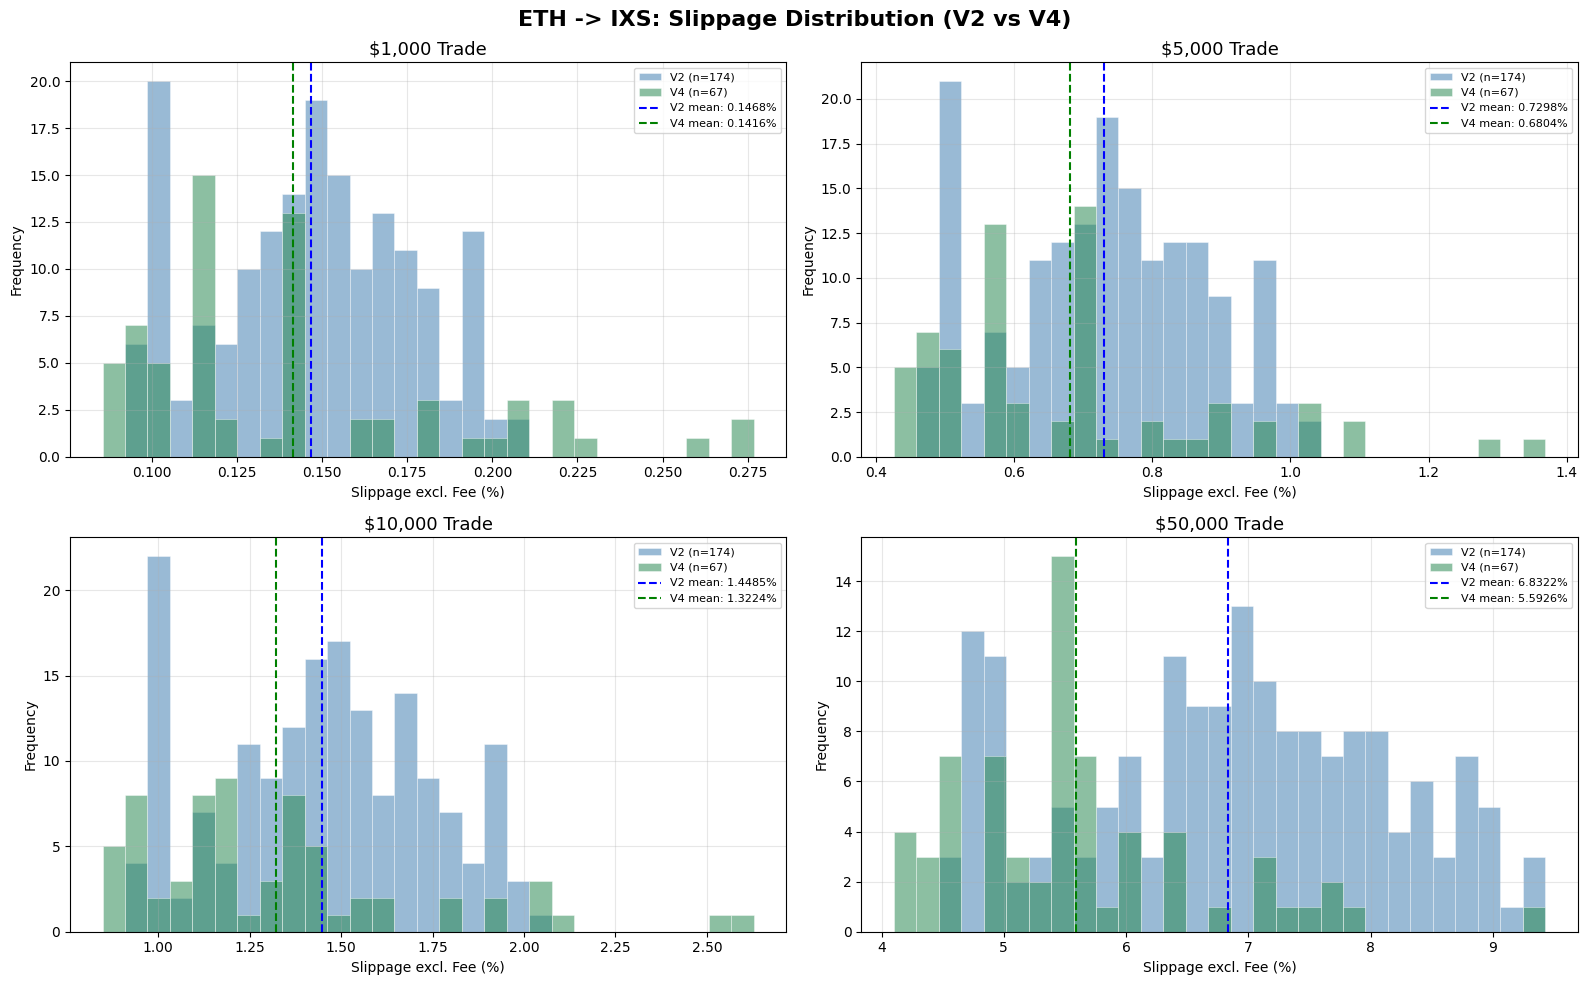

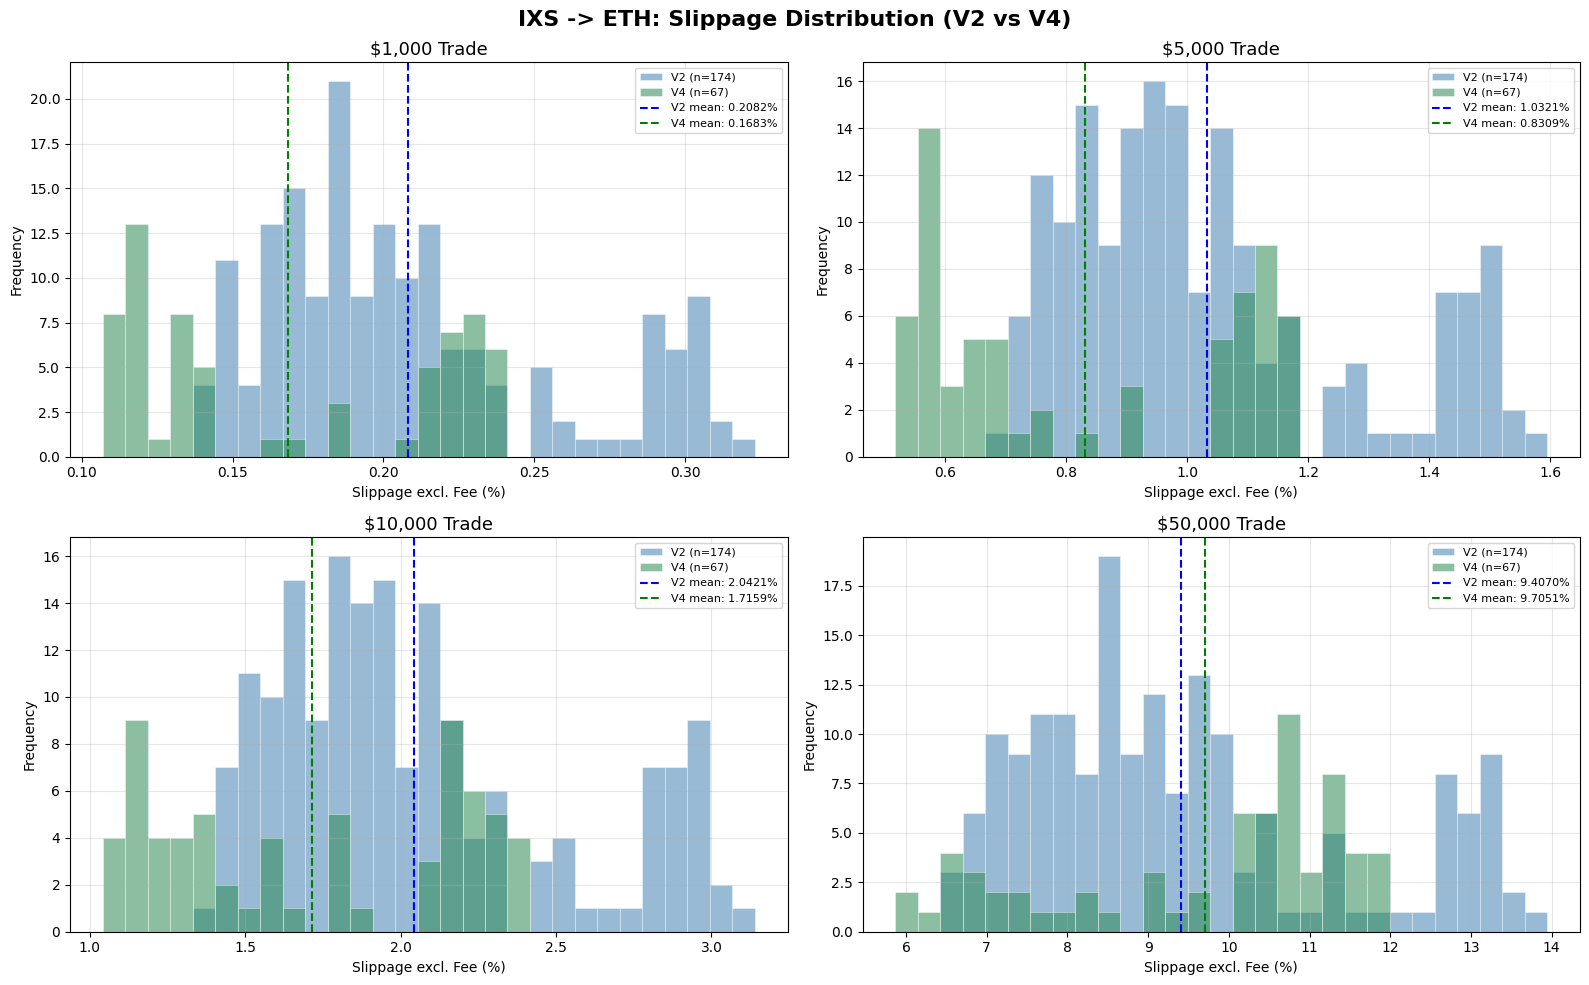

In [21]:
def plot_slippage_histograms(v2_results, v4_results, v2_amounts, v4_amounts,
                             title, sizes_usd):
    """Plot 2x2 overlaid histograms comparing V2 vs V4 slippage distributions."""
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(title, fontsize=16, fontweight='bold')

    for idx, (usd, v2_amt, v4_amt) in enumerate(zip(sizes_usd, v2_amounts, v4_amounts)):
        ax = axes[idx // 2][idx % 2]

        v2_vals = [get_trade(r, v2_amt)["gross_slippage_pct"] for r in v2_results
                   if "error" not in r and has_trade(r, v2_amt)]
        v4_vals = [get_trade(r, v4_amt)["gross_slippage_pct"] for r in v4_results
                   if "error" not in r and has_trade(r, v4_amt)]

        all_vals = v2_vals + v4_vals
        if not all_vals:
            ax.text(0.5, 0.5, "No data", transform=ax.transAxes, ha="center")
            continue

        bins = np.linspace(min(all_vals), max(all_vals), 30)

        ax.hist(v2_vals, bins=bins, alpha=0.55, color='steelblue', edgecolor='white',
                linewidth=0.5, label=f'V2 (n={len(v2_vals)})')
        ax.hist(v4_vals, bins=bins, alpha=0.55, color='seagreen', edgecolor='white',
                linewidth=0.5, label=f'V4 (n={len(v4_vals)})')

        # Mean lines
        if v2_vals:
            v2_mean = np.mean(v2_vals)
            ax.axvline(v2_mean, color='blue', linestyle='--', linewidth=1.5,
                       label=f'V2 mean: {v2_mean:.4f}%')
        if v4_vals:
            v4_mean = np.mean(v4_vals)
            ax.axvline(v4_mean, color='green', linestyle='--', linewidth=1.5,
                       label=f'V4 mean: {v4_mean:.4f}%')

        ax.set_title(f'${usd:,} Trade', fontsize=13)
        ax.set_xlabel('Slippage excl. Fee (%)')
        ax.set_ylabel('Frequency')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

# Buy direction histogram
fig = plot_slippage_histograms(
    v2_buy_results, v4_buy_results, trade_eth_wei, trade_eth_wei_v4,
    'ETH -> IXS: Slippage Distribution (V2 vs V4)', TRADE_SIZES_USD
)
plt.savefig('plots/ixs_buy_slippage_histogram.png', dpi=150, bbox_inches='tight')
plt.show()

# Sell direction histogram
fig = plot_slippage_histograms(
    v2_sell_results, v4_sell_results, trade_ixs_wei, trade_ixs_wei_v4,
    'IXS -> ETH: Slippage Distribution (V2 vs V4)', TRADE_SIZES_USD
)
plt.savefig('plots/ixs_sell_slippage_histogram.png', dpi=150, bbox_inches='tight')
plt.show()

### Summary Statistics

In [22]:
def print_slippage_summary(label, v2_results, v4_results, v2_amounts, v4_amounts, sizes_usd):
    print(f"\n{'='*60}")
    print(f"{label}")
    print(f"{'='*60}")
    print(f"{'Trade Size':<12} {'V2 Avg %':<12} {'V4 Avg %':<12} {'Improvement':<12}")
    print("-" * 48)
    for usd, v2_amt, v4_amt in zip(sizes_usd, v2_amounts, v4_amounts):
        v2_s = [get_trade(r, v2_amt)["gross_slippage_pct"] for r in v2_results
                if "error" not in r and has_trade(r, v2_amt)]
        v4_s = [get_trade(r, v4_amt)["gross_slippage_pct"] for r in v4_results
                if "error" not in r and has_trade(r, v4_amt)]
        v2_avg = np.mean(v2_s) if v2_s else 0
        v4_avg = np.mean(v4_s) if v4_s else 0
        imp = (v2_avg - v4_avg) / v2_avg * 100 if v2_avg > 0 else 0
        print(f"${usd:>6,}     {v2_avg:<12.4f} {v4_avg:<12.4f} {imp:>8.1f}%")

print_slippage_summary("ETH → IXS (Buying IXS)",
    v2_buy_results, v4_buy_results, trade_eth_wei, trade_eth_wei_v4, TRADE_SIZES_USD)
print_slippage_summary("IXS → ETH (Selling IXS)",
    v2_sell_results, v4_sell_results, trade_ixs_wei, trade_ixs_wei_v4, TRADE_SIZES_USD)


ETH → IXS (Buying IXS)
Trade Size   V2 Avg %     V4 Avg %     Improvement 
------------------------------------------------
$ 1,000     0.1468       0.1416            3.6%
$ 5,000     0.7298       0.6804            6.8%
$10,000     1.4485       1.3224            8.7%
$50,000     6.8322       5.5926           18.1%

IXS → ETH (Selling IXS)
Trade Size   V2 Avg %     V4 Avg %     Improvement 
------------------------------------------------
$ 1,000     0.2082       0.1683           19.2%
$ 5,000     1.0321       0.8309           19.5%
$10,000     2.0421       1.7159           16.0%
$50,000     9.4070       9.7051           -3.2%


---

## Additional Analysis: Net Cost, Break-Even, and Capital Efficiency

The questions above focus on gross slippage (fee excluded). But the total cost to a trader includes the LP fee. V4 charges a higher fee than V2 (on-chain `lpFee` vs V2's immutable 30 bps), so we need to check whether V4's slippage savings outweigh the fee premium.

### Total Execution Cost

Uses `net_slippage_pct` directly from on-chain data -- the actual deviation between spot price and execution price, with fees already included. No hardcoded fee values.

V2 fee: 0.30% (immutable UniV2 contract)
V4 fee: 0.70% (from on-chain lpFee = 7000 ppm)
Fee premium: 0.40pp


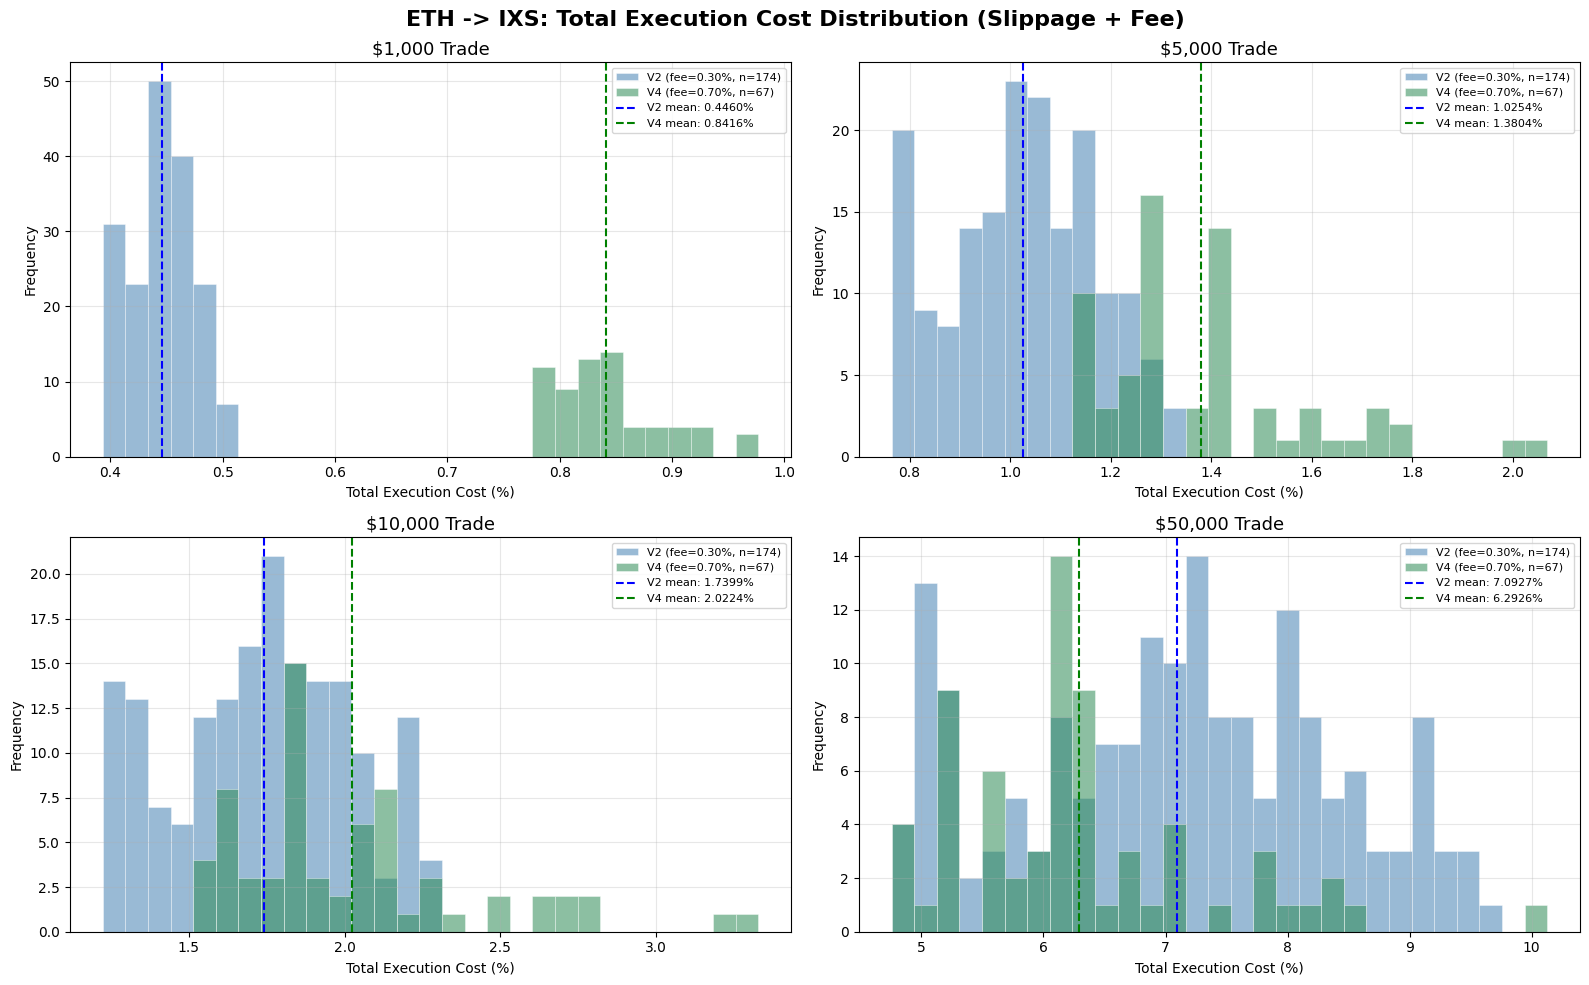

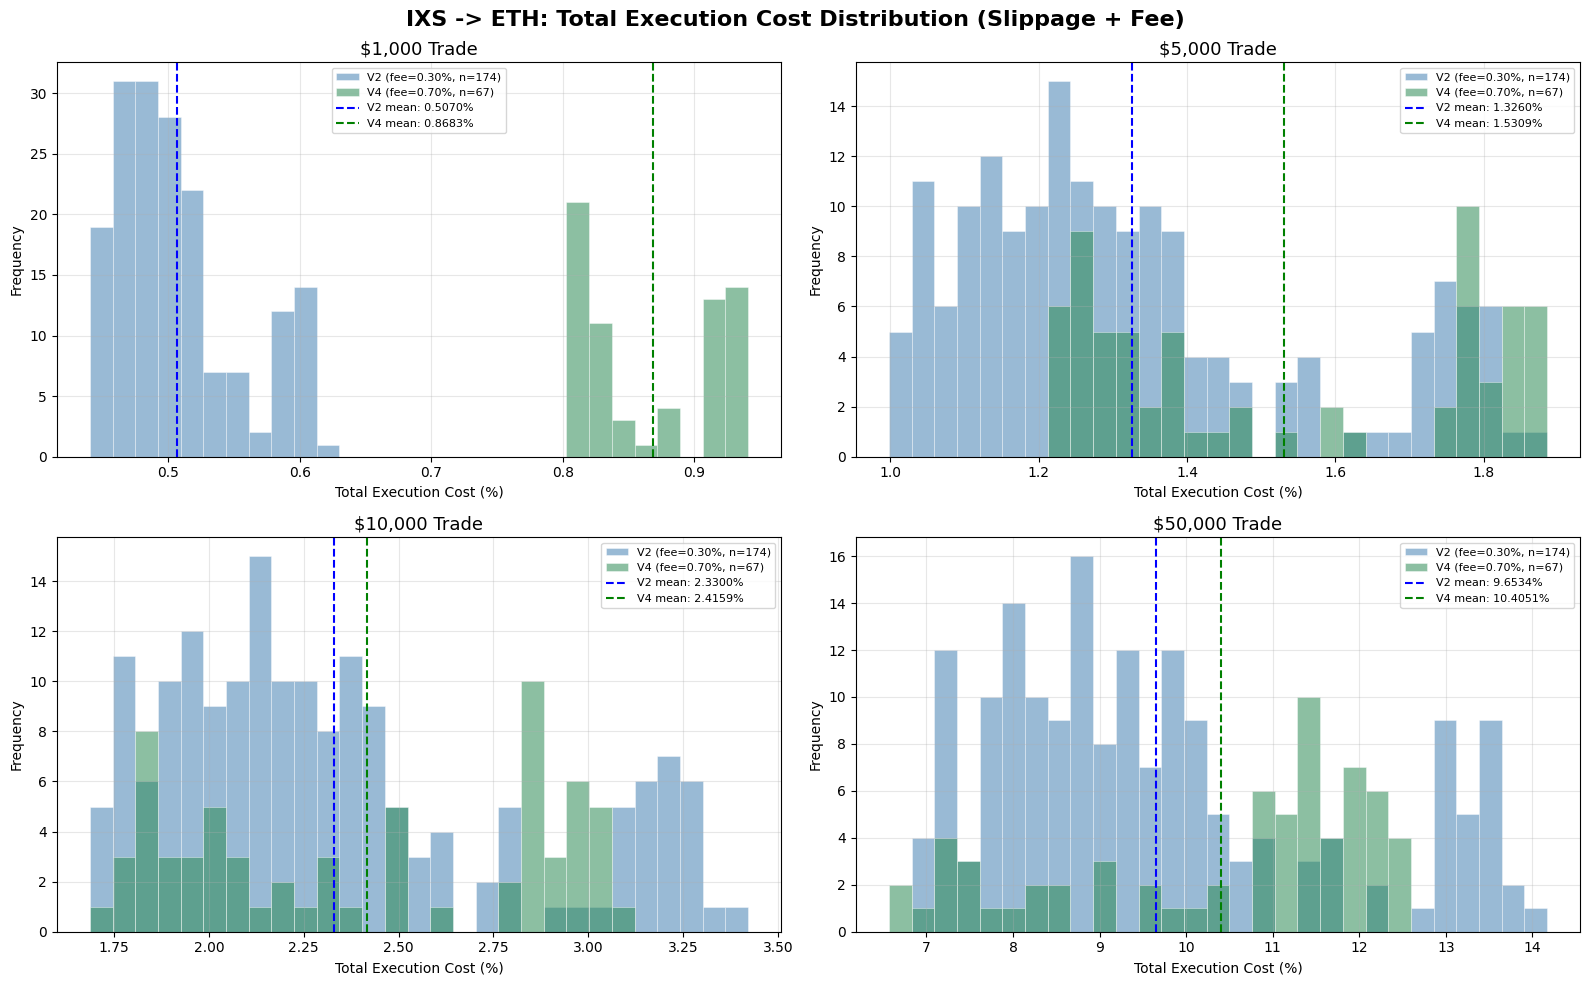

In [23]:
# Extract actual fees from on-chain data (not hardcoded)
v4_fees_ppm = [r["lp_fee"] for r in v4_buy_results if "error" not in r and "lp_fee" in r]
v4_fee_pct = np.median(v4_fees_ppm) / 10_000  # ppm -> percentage

# V2 fee is 30 bps, immutable in the UniswapV2 contract (no on-chain field to read)
v2_fee_pct = 0.30

print(f"V2 fee: {v2_fee_pct:.2f}% (immutable UniV2 contract)")
print(f"V4 fee: {v4_fee_pct:.2f}% (from on-chain lpFee = {int(np.median(v4_fees_ppm))} ppm)")
print(f"Fee premium: {v4_fee_pct - v2_fee_pct:.2f}pp")


def plot_net_slippage_histograms(v2_results, v4_results, v2_amounts, v4_amounts,
                                  title, sizes_usd, v2_fee_label, v4_fee_label):
    """Plot 2x2 overlaid histograms comparing V2 vs V4 total execution cost distributions."""
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(title, fontsize=16, fontweight='bold')

    for idx, (usd, v2_amt, v4_amt) in enumerate(zip(sizes_usd, v2_amounts, v4_amounts)):
        ax = axes[idx // 2][idx % 2]

        v2_vals = [get_trade(r, v2_amt)["net_slippage_pct"] for r in v2_results
                   if "error" not in r and has_trade(r, v2_amt)
                   and "net_slippage_pct" in get_trade(r, v2_amt)]
        v4_vals = [get_trade(r, v4_amt)["net_slippage_pct"] for r in v4_results
                   if "error" not in r and has_trade(r, v4_amt)
                   and "net_slippage_pct" in get_trade(r, v4_amt)]

        all_vals = v2_vals + v4_vals
        if not all_vals:
            ax.text(0.5, 0.5, "No data", transform=ax.transAxes, ha="center")
            continue

        bins = np.linspace(min(all_vals), max(all_vals), 30)

        ax.hist(v2_vals, bins=bins, alpha=0.55, color='steelblue', edgecolor='white',
                linewidth=0.5, label=f'V2 ({v2_fee_label}, n={len(v2_vals)})')
        ax.hist(v4_vals, bins=bins, alpha=0.55, color='seagreen', edgecolor='white',
                linewidth=0.5, label=f'V4 ({v4_fee_label}, n={len(v4_vals)})')

        # Mean lines
        if v2_vals:
            v2_mean = np.mean(v2_vals)
            ax.axvline(v2_mean, color='blue', linestyle='--', linewidth=1.5,
                       label=f'V2 mean: {v2_mean:.4f}%')
        if v4_vals:
            v4_mean = np.mean(v4_vals)
            ax.axvline(v4_mean, color='green', linestyle='--', linewidth=1.5,
                       label=f'V4 mean: {v4_mean:.4f}%')

        ax.set_title(f'${usd:,} Trade', fontsize=13)
        ax.set_xlabel('Total Execution Cost (%)')
        ax.set_ylabel('Frequency')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

v2_fee_label = f"fee={v2_fee_pct:.2f}%"
v4_fee_label = f"fee={v4_fee_pct:.2f}%"

# Buy direction: ETH -> IXS
fig = plot_net_slippage_histograms(
    v2_buy_results, v4_buy_results, trade_eth_wei, trade_eth_wei_v4,
    'ETH -> IXS: Total Execution Cost Distribution (Slippage + Fee)', TRADE_SIZES_USD,
    v2_fee_label, v4_fee_label
)
plt.savefig('plots/ixs_buy_net_slippage.png', dpi=150, bbox_inches='tight')
plt.show()

# Sell direction: IXS -> ETH
fig = plot_net_slippage_histograms(
    v2_sell_results, v4_sell_results, trade_ixs_wei, trade_ixs_wei_v4,
    'IXS -> ETH: Total Execution Cost Distribution (Slippage + Fee)', TRADE_SIZES_USD,
    v2_fee_label, v4_fee_label
)
plt.savefig('plots/ixs_sell_net_slippage.png', dpi=150, bbox_inches='tight')
plt.show()

### Break-Even Analysis

At what trade size does V4's slippage savings overcome the fee premium?

In [24]:
# Net slippage summary using actual on-chain fees (net_slippage_pct from results)
buy_summary = compute_net_slippage_summary(
    v2_buy_results, v4_buy_results, trade_eth_wei, trade_eth_wei_v4, TRADE_SIZES_USD,
)
sell_summary = compute_net_slippage_summary(
    v2_sell_results, v4_sell_results, trade_ixs_wei, trade_ixs_wei_v4, TRADE_SIZES_USD,
)

# Print summary tables
for label, df in [("ETH -> IXS (Buying)", buy_summary), ("IXS -> ETH (Selling)", sell_summary)]:
    print(f"\n{'='*70}")
    print(f"  {label}: Gross vs Net (Total Execution Cost)")
    print(f"{'='*70}")
    print(f"{'Size':<8} {'V2 Gross':>10} {'V4 Gross':>10} {'V2 Net':>10} {'V4 Net':>10} {'Net D':>10}")
    print("-" * 58)
    for _, row in df.iterrows():
        delta = row['v2_net_avg'] - row['v4_net_avg']
        winner = "V4" if delta > 0 else "V2"
        print(f"${row['size_usd']:>6,} {row['v2_gross_avg']:>9.4f}% {row['v4_gross_avg']:>9.4f}% "
              f"{row['v2_net_avg']:>9.4f}% {row['v4_net_avg']:>9.4f}% {delta:>+8.4f}pp ({winner})")

# Find break-even trade sizes (log-space interpolation for log-scale plots)
buy_be = find_breakeven_trade_size(
    buy_summary['v2_net_avg'].tolist(),
    buy_summary['v4_net_avg'].tolist(),
    TRADE_SIZES_USD,
)
sell_be = find_breakeven_trade_size(
    sell_summary['v2_net_avg'].tolist(),
    sell_summary['v4_net_avg'].tolist(),
    TRADE_SIZES_USD,
)

fee_premium = v4_fee_pct - v2_fee_pct
print(f"\n{'='*70}")
print(f"  Break-Even Analysis (V4 fee premium: {fee_premium:.2f}pp)")
print(f"  Fees from on-chain data: V2={v2_fee_pct:.2f}%, V4={v4_fee_pct:.2f}%")
print(f"{'='*70}")

def _describe_breakeven(label: str, be, df):
    """Print break-even result for one direction."""
    all_v4_cheaper = all(df['v4_net_avg'].iloc[i] < df['v2_net_avg'].iloc[i] for i in range(len(df)))
    all_v2_cheaper = all(df['v2_net_avg'].iloc[i] < df['v4_net_avg'].iloc[i] for i in range(len(df)))
    if be:
        print(f"  {label}: V4 becomes cheaper above ~${be:,.0f}")
    elif all_v4_cheaper:
        print(f"  {label}: V4 is cheaper at all tested sizes (break-even below $1K)")
    elif all_v2_cheaper:
        print(f"  {label}: V2 is cheaper at all tested sizes (no break-even)")
    else:
        print(f"  {label}: Mixed results, no clear crossover")

_describe_breakeven("ETH->IXS", buy_be, buy_summary)
_describe_breakeven("IXS->ETH", sell_be, sell_summary)


  ETH -> IXS (Buying): Gross vs Net (Total Execution Cost)
Size       V2 Gross   V4 Gross     V2 Net     V4 Net      Net D
----------------------------------------------------------
$1,000.0    0.1468%    0.1416%    0.4460%    0.8416%  -0.3956pp (V2)
$5,000.0    0.7298%    0.6804%    1.0254%    1.3804%  -0.3550pp (V2)
$10,000.0    1.4485%    1.3224%    1.7399%    2.0224%  -0.2825pp (V2)
$50,000.0    6.8322%    5.5926%    7.0927%    6.2926%  +0.8001pp (V4)

  IXS -> ETH (Selling): Gross vs Net (Total Execution Cost)
Size       V2 Gross   V4 Gross     V2 Net     V4 Net      Net D
----------------------------------------------------------
$1,000.0    0.2082%    0.1683%    0.5070%    0.8683%  -0.3613pp (V2)
$5,000.0    1.0321%    0.8309%    1.3260%    1.5309%  -0.2049pp (V2)
$10,000.0    2.0421%    1.7159%    2.3300%    2.4159%  -0.0859pp (V2)
$50,000.0    9.4070%    9.7051%    9.6534%   10.4051%  -0.7517pp (V2)

  Break-Even Analysis (V4 fee premium: 0.40pp)
  Fees from on-chain data: V2

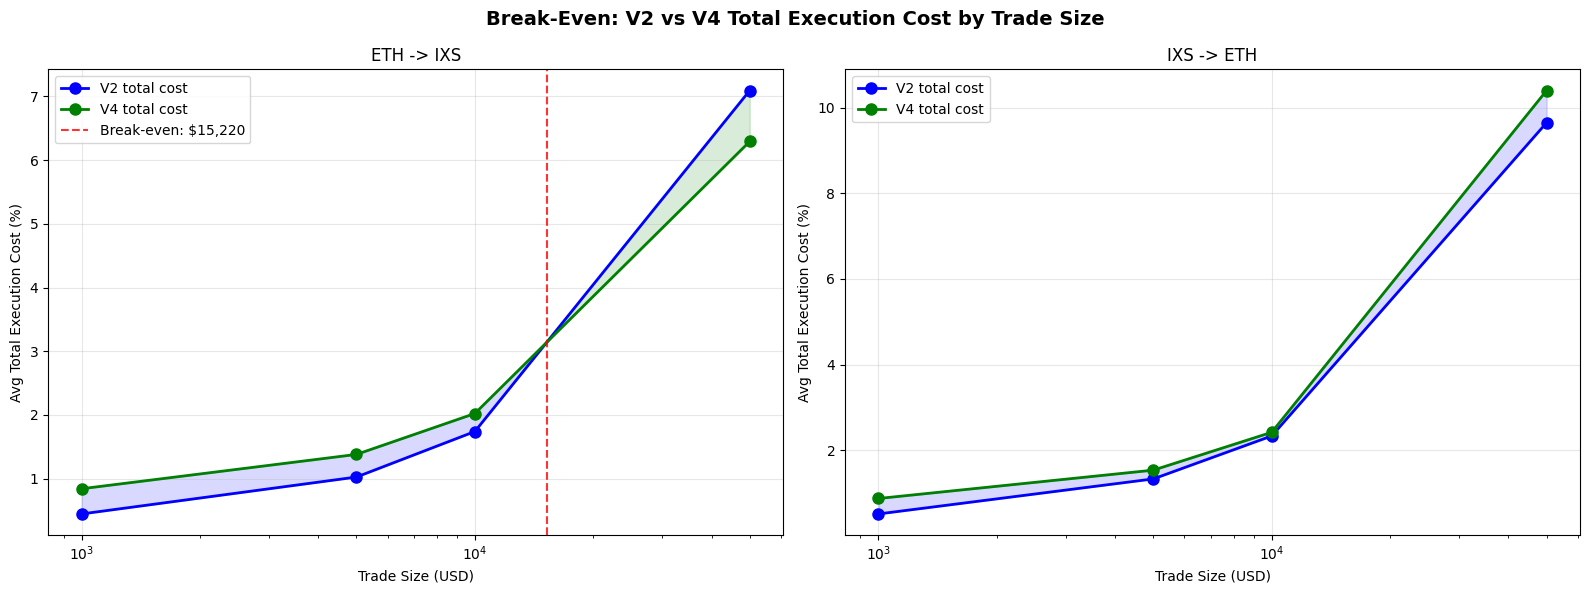

In [25]:
# Break-even visualization: V2 vs V4 avg total execution cost as function of trade size
# Use dense interpolation in log-space so the crossing and shading are accurate
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Break-Even: V2 vs V4 Total Execution Cost by Trade Size', fontsize=14, fontweight='bold')

for ax, df, label, be in [(ax1, buy_summary, 'ETH -> IXS', buy_be),
                           (ax2, sell_summary, 'IXS -> ETH', sell_be)]:
    sizes = df['size_usd'].values
    v2_vals = df['v2_net_avg'].values
    v4_vals = df['v4_net_avg'].values

    # Dense interpolation in log-space for smooth shading
    log_sizes = np.log10(sizes)
    log_dense = np.linspace(log_sizes[0], log_sizes[-1], 200)
    dense_sizes = 10**log_dense
    v2_dense = np.interp(log_dense, log_sizes, v2_vals)
    v4_dense = np.interp(log_dense, log_sizes, v4_vals)

    ax.plot(sizes, v2_vals, 'b-o', linewidth=2, markersize=8, label='V2 total cost')
    ax.plot(sizes, v4_vals, 'g-o', linewidth=2, markersize=8, label='V4 total cost')

    # Shade: green where V4 cheaper, blue where V2 cheaper
    ax.fill_between(dense_sizes, v2_dense, v4_dense,
                    where=(v2_dense > v4_dense), alpha=0.15, color='green',
                    interpolate=True)
    ax.fill_between(dense_sizes, v2_dense, v4_dense,
                    where=(v2_dense <= v4_dense), alpha=0.15, color='blue',
                    interpolate=True)

    if be:
        ax.axvline(be, color='red', linestyle='--', alpha=0.8, label=f'Break-even: ${be:,.0f}')

    ax.set_xlabel('Trade Size (USD)')
    ax.set_ylabel('Avg Total Execution Cost (%)')
    ax.set_title(label)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log')

plt.tight_layout()
plt.savefig('plots/ixs_breakeven_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

### Capital Efficiency

**Capital efficiency ratio** measures how much less slippage (price impact) V4 delivers compared to V2 for the same trade size, excluding fees:

$$\text{CE Ratio} = \frac{\bar{S}_{\text{V2,gross}}}{\bar{S}_{\text{V4,gross}}} \quad \text{where} \quad \bar{S} = \frac{1}{N}\sum_{i=1}^{N} S_i$$

$S_i$ is the gross slippage (price impact only, fees excluded) at sampled block $i$, and $N$ is the number of sampled blocks per period.

- A ratio of **1.2x** means V4 produces 20% less price impact than V2 for the same trade -- the concentrated liquidity is 1.2x more capital-efficient.
- A ratio **below 1x** means V2 has lower price impact (V4 liquidity is thinner at that trade size).

This metric isolates the effect of liquidity concentration from the fee structure. It answers: *given the same trade, how much better is V4 at minimizing price movement?*

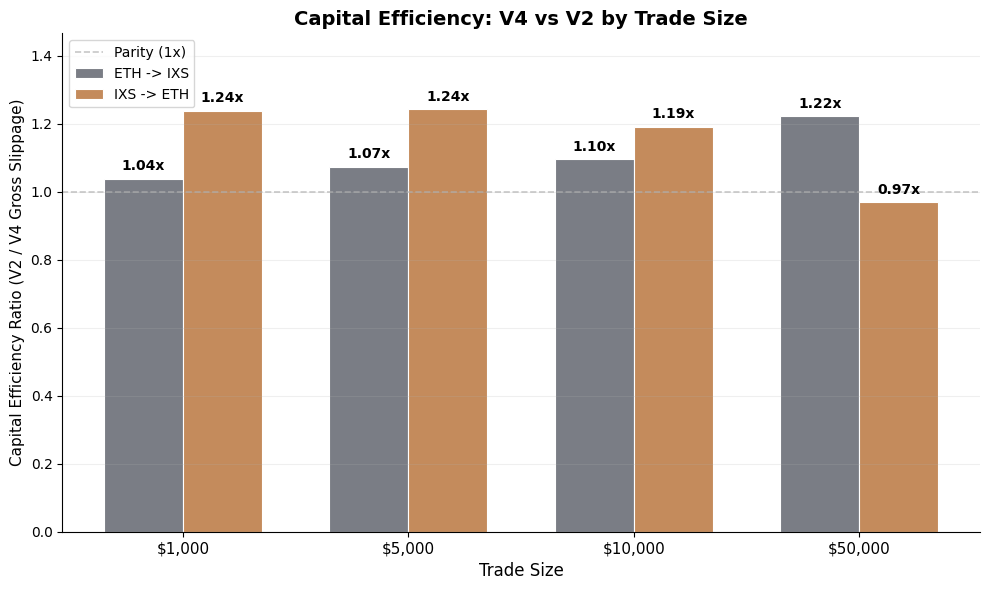

Capital Efficiency Ratios (V2 gross / V4 gross):
  $ 1,000:  ETH->IXS = 1.04x,  IXS->ETH = 1.24x
  $ 5,000:  ETH->IXS = 1.07x,  IXS->ETH = 1.24x
  $10,000:  ETH->IXS = 1.10x,  IXS->ETH = 1.19x
  $50,000:  ETH->IXS = 1.22x,  IXS->ETH = 0.97x


In [31]:
# Compute capital efficiency ratios for each direction and trade size
fig, ax = plt.subplots(figsize=(10, 6))

buy_ratios = [compute_capital_efficiency_ratio(row['v2_gross_avg'], row['v4_gross_avg'])
              for _, row in buy_summary.iterrows()]
sell_ratios = [compute_capital_efficiency_ratio(row['v2_gross_avg'], row['v4_gross_avg'])
               for _, row in sell_summary.iterrows()]

x = np.arange(len(TRADE_SIZES_USD))
width = 0.35

# Muted palette: slate grey + dusty terracotta
bars1 = ax.bar(x - width/2, buy_ratios, width, label='ETH -> IXS',
               color='#7A7D85', edgecolor='white', linewidth=0.8)
bars2 = ax.bar(x + width/2, sell_ratios, width, label='IXS -> ETH',
               color='#C48B5C', edgecolor='white', linewidth=0.8)

ax.set_xlabel('Trade Size', fontsize=12)
ax.set_ylabel('Capital Efficiency Ratio (V2 / V4 Gross Slippage)', fontsize=11)
ax.set_title('Capital Efficiency: V4 vs V2 by Trade Size', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'${s:,}' for s in TRADE_SIZES_USD], fontsize=11)
ax.axhline(y=1, color='#B0B0B0', linestyle='--', linewidth=1.2, alpha=0.7, label='Parity (1x)')
ax.legend(fontsize=10, loc='upper left')
ax.grid(True, alpha=0.2, axis='y')
ax.set_ylim(0, max(max(buy_ratios), max(sell_ratios)) * 1.18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height != float('inf'):
            ax.annotate(f'{height:.2f}x',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 4), textcoords="offset points",
                        ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('plots/ixs_capital_efficiency.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary
print("Capital Efficiency Ratios (V2 gross / V4 gross):")
for i, usd in enumerate(TRADE_SIZES_USD):
    print(f"  ${usd:>6,}:  ETH->IXS = {buy_ratios[i]:.2f}x,  IXS->ETH = {sell_ratios[i]:.2f}x")

---

## Q4. V4 Liquidity Distribution Across Tick Ranges

Scan the V4 tick bitmap to find initialized ticks and reconstruct the active liquidity per range.

In [34]:
# Data already fetched above -- just print the summary
print(f"Initialized tick ranges: {len(df_liq)}")
print(f"Current tick: {slot_info['tick']}")
print(f"Current liquidity: {slot_info['liquidity']:,}")
print("\nTick ranges:")
for _, row in df_liq.iterrows():
    active = "<- ACTIVE" if row['tick_lower'] <= slot_info['tick'] < row['tick_upper'] else ""
    print(f"  [{int(row['tick_lower']):>8} -> {int(row['tick_upper']):>8}]  L = {int(row['active_liquidity']):>25,}  {active}")

Initialized tick ranges: 6
Current tick: 104377
Current liquidity: 40,944,451,797,831,193,660,012

Tick ranges:
  [   92100 ->    92150]  L =                         0  
  [   92150 ->    92950]  L = 40,944,451,797,831,193,660,012  
  [   92950 ->   103900]  L = 48,812,350,825,352,456,355,462  
  [  103900 ->   104350]  L = 40,944,451,797,831,193,660,012  
  [  104350 ->   115700]  L = 40,944,451,797,831,193,660,012  <- ACTIVE
  [  115700 ->   115750]  L =                         0  


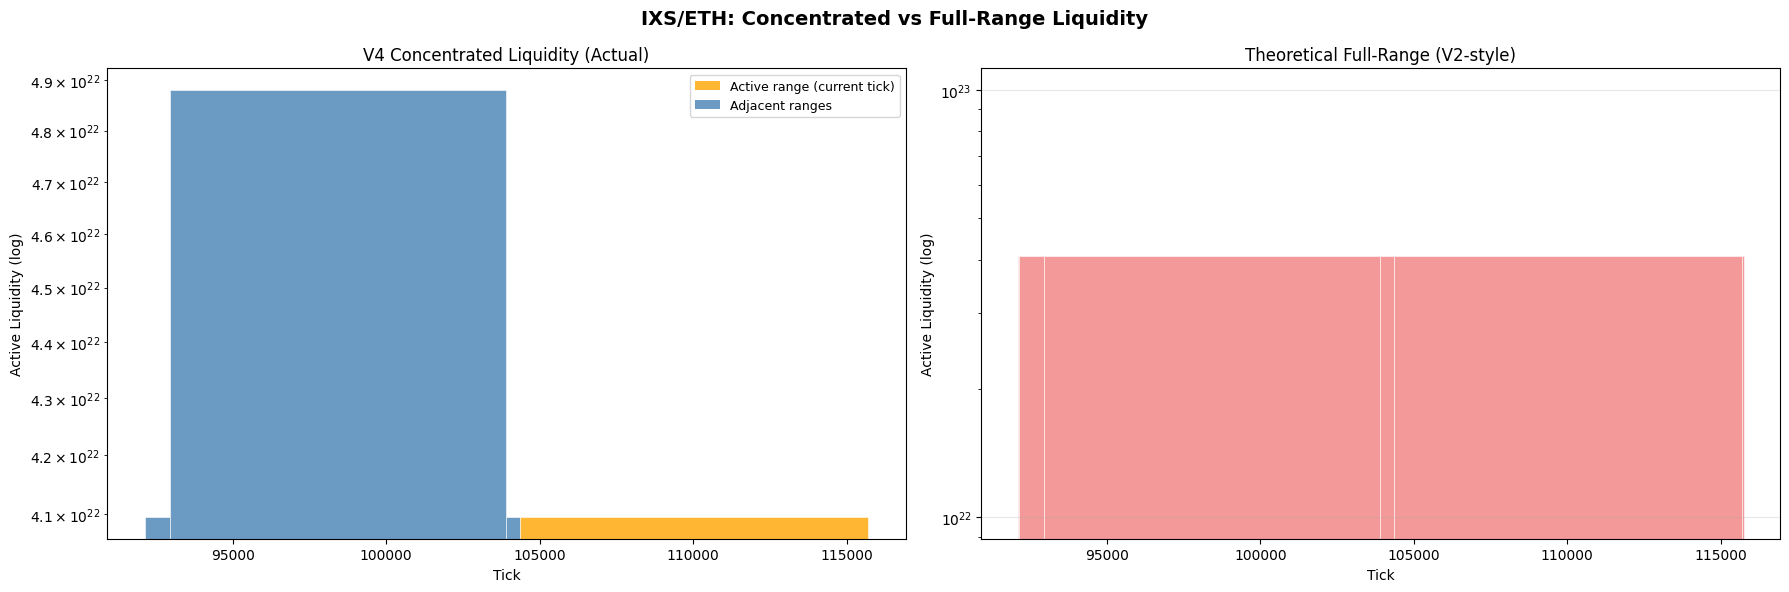

In [35]:
if not df_liq.empty:
    from matplotlib.patches import Patch
    import math

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Convert to float to avoid C long overflow with large liquidity values
    liq_values = [float(v) for v in df_liq['active_liquidity']]

    # Left: Concentrated distribution (actual) -- bars at real tick positions
    for _, row in df_liq.iterrows():
        is_active = row['tick_lower'] <= slot_info['tick'] < row['tick_upper']
        color = 'orange' if is_active else 'steelblue'
        width = int(row['tick_upper'] - row['tick_lower'])
        liq = float(row['active_liquidity'])
        ax1.bar(row['tick_lower'], liq, width=width, align='edge',
                color=color, alpha=0.8, edgecolor='white', linewidth=0.5)

    ax1.set_yscale('log')
    ax1.set_xlabel('Tick')
    ax1.set_ylabel('Active Liquidity (log)')
    ax1.set_title('V4 Concentrated Liquidity (Actual)')
    ax1.grid(True, alpha=0.3, axis='y')

    legend_left = [
        Patch(facecolor='orange', alpha=0.8, label='Active range (current tick)'),
        Patch(facecolor='steelblue', alpha=0.8, label='Adjacent ranges'),
    ]
    ax1.legend(handles=legend_left, fontsize=9)

    # Right: Theoretical full-range (uniform) -- same tick positions, uniform L
    total_liq = float(slot_info['liquidity'])
    for _, row in df_liq.iterrows():
        width = int(row['tick_upper'] - row['tick_lower'])
        ax2.bar(row['tick_lower'], total_liq, width=width, align='edge',
                color='lightcoral', alpha=0.8, edgecolor='white', linewidth=0.5)

    ax2.set_yscale('log')
    ax2.set_xlabel('Tick')
    ax2.set_ylabel('Active Liquidity (log)')
    ax2.set_title('Theoretical Full-Range (V2-style)')
    ax2.grid(True, alpha=0.3, axis='y')

    fig.suptitle('IXS/ETH: Concentrated vs Full-Range Liquidity', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('plots/ixs_liquidity_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()

---

## Q5. Concentrated vs Full-Range: Effect on Execution Quality

**V2** spreads liquidity uniformly from tick $-\infty$ to $+\infty$. For reserve $x$:

$$S_{\text{V2}} = \frac{\Delta x}{x + \Delta x}$$

**V4** concentrates liquidity $L$ in a narrow range around the current price. Within that range:

$$S_{\text{V4}} = 1 - \frac{1}{\left(1 + \frac{\Delta x \sqrt{p}}{L}\right)^2}$$

Same TVL concentrated into a smaller range produces a larger $L$, and thus lower slippage for the same trade size. The tradeoff: concentrated liquidity is only effective while price stays within the range. If price moves outside, that liquidity becomes inactive. This is why active management (Arrakis rebalancing) matters — it shifts the range as price moves.

In [38]:
# Export summary data for D3 client synthesis
buy_summary_export = buy_summary.copy()
buy_summary_export['direction'] = 'ETH->IXS'
buy_summary_export['breakeven_usd'] = float(buy_be) if buy_be else np.nan
buy_summary_export['capital_efficiency'] = buy_ratios

sell_summary_export = sell_summary.copy()
sell_summary_export['direction'] = 'IXS->ETH'
sell_summary_export['breakeven_usd'] = float(sell_be) if sell_be else np.nan
sell_summary_export['capital_efficiency'] = sell_ratios

slippage_export = pd.concat([buy_summary_export, sell_summary_export], ignore_index=True)
slippage_export.to_csv('data/slippage_summary.csv', index=False)
print("Exported slippage summary to data/slippage_summary.csv")
print(slippage_export.to_string(index=False))

Exported slippage summary to data/slippage_summary.csv
 size_usd  v2_gross_avg  v4_gross_avg  v2_net_avg  v4_net_avg  gross_improvement_pct  net_improvement_pct direction  breakeven_usd  capital_efficiency
     1000      0.146842      0.141569    0.445963    0.841569               3.590923           -88.708210  ETH->IXS   15219.692184            1.037247
     5000      0.729756      0.680410    1.025400    1.380410               6.761980           -34.621556  ETH->IXS   15219.692184            1.072524
    10000      1.448527      1.322435    1.739914    2.022435               8.704868           -16.237625  ETH->IXS   15219.692184            1.095349
    50000      6.832195      5.592620    7.092704    6.292620              18.143147            11.280385  ETH->IXS   15219.692184            1.221645
     1000      0.208236      0.168296    0.506990    0.868296              19.180116           -71.264995  IXS->ETH            NaN            1.237319
     5000      1.032138      0.830926  